# **Analyse und Vorhersage von Diamant-Preisen**
<br>**Projekt für Angewandte Programmierung**
<br>**Arne Decker**

## Inhalt
* [Business Understanding](#businssunderstanding)
* [Data Understanding](#dataunderstanding)
* [Data Preparation](#datapreparation)
* [Modeling und Evaluation](#modelingundevaluation)
* [Rücksprung und weitere Iteration zur Optimierung](#optimierung)
* [Ergebnis](#ergebnis)
* [Quellenverzeichnis](#quellenverzeichnis)

# **Business Understanding**<a class="anchor" id="businssunderstanding"></a>

Die Bestimmung des Preises eines Diamanten erfolgt anhand verschiedener Merkmale, die Aufschluss über die Qualität und Beschaffenheit des jeweiligen Diamanten geben. Die wichtigsten Faktoren sind die sogenannten vier C‘s: Carat (Karat/Gewicht), Color (Farbe), Cut (Schliff) und Clarity (Reinheit). Daneben gibt es allerdings noch weitere Faktoren. [[1]](#diamanten-4cs)

Durch eine automatisierte Preisbestimmung kann auf verschiedene Weise Business Value schaffen. Zunächst kann die Automatisierung Personalkosten einsparen Aufwände reduzieren, da die Preise nicht mehr manuell bestimmt werden müssen. Ein Algorithmus kann aber auch von potenziellen Kunden genutzt werden. Diese haben oft keine Fachexpertise und können Preise von Diamanten, die beispielsweise von Juwelieren ausgegeben werden, schwer überprüfen. Dadurch sind Kunden anfällig für überhöhte oder viel zu niedrige Preise.

Ziel ist es daher, einen Regressionsmodell zu erstellen, in das verschiedene Merkmale des Diamanten eingegeben werden. Das Regressionsmodell soll dann einen Preis für den jeweiligen Diamanten berechnen. Wenn beispielsweise ein Kunde einen Diamanten bei einem Juwelier kaufen oder verkaufen möchte, kann auf diese Weise eine Orientierungshilfe für den Preis ermittelt werden, damit der jeweilige Diamant nicht signifikant über oder unter Wert gehandelt wird. Eine exakte Vorhersage der Diamantenpreise wird aufgrund der geringen Menge an Daten und Attribute sowie der Komplexität des Sachverhalts vermutlich nicht möglich sein. Das Modell soll stattdessen nur eine Orientierungshilfe sein. Daher sollen die vom Modell ermittelten Preise nicht mehr als 15% vom tatsächlichen Preis des Diamanten abweichen.

Die Erstellung des Modells erfolgt nach der CRISP-DM-Modell [[2]](#crispdmmodellbild):

![title](crispdm.jpg) 

1.	Business Understanding: Definition der Ziele und Anforderungen
2.	Data Understanding: Analyse der Daten auf Qualität und Zusammenhänge
3.	Data Preparation: Erstellung einen finalen Datensatzes für weitere Bearbeitung
4.	Modeling: Erstellung und Optimierung eines Modells
5.	Evaluation: Beurteilung des Modells und Abgleich mit den Anforderungen
6.	Deployment: Einführung des Modells[[3]](#crispdmmodell)

Die Phasen Modeling und Evaluation werden hier in einer Phase zusammengefasst, um eine einfachere Betrachtung zu ermöglichen. Das Deployment ist nicht Teil der Betrachtung.

Das [vorliegende Datenset](https://www.kaggle.com/shivam2503/diamonds) enthält Daten von circa 54.000 Diamanten mit jeweils neun Merkmalen und dem jeweiligen Preis und stammt von der Data Science Plattform Kaggle[[4]](#datensatz).

In [2]:
#Alle verwendeten Importe und Einstellungen
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))

import scipy

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer

# **Data Understanding**<a class="anchor" id="dataunderstanding"></a>

Der vorliegende Datensatz fasst insgesamt 53.941 Diamanten mit folgenden Attributen:
* Price: Preis in US-Dollar
* Carat: Karat (Gewicht)
* Cut: Schliff
* Color: Farbe
* Clarity: Reinheit
* X: Länge
* Y: Breite
* Z: Höhe
* Depth: Anteil des Pavillions an der Höhe (%)
* Table: Anteil des Tischs an der Länge (%)

### Abmessungen des Diamanten[[5]](#abmessungen)
![title](abmessungen.jpg)

Zunächst sollen die einzelnen Merkmale univariat analysiert werden, anshcließend erfolgt dann eine multivariate Analyse.
<br>Zielvariable ist dabei der Preis.

In [8]:
#Datensatz laden
data = pd.read_csv('diamonds.csv') #https://www.kaggle.com/shivam2503/diamonds
data = data.drop('Unnamed: 0', 1) #Zeilennummer in CSV-Datei, kann daher entfernt werden

print(data.head(20))

    carat        cut color clarity  depth  table  price     x     y     z
0    0.23      Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1    0.21    Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2    0.23       Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3    0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4    0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
5    0.24  Very Good     J    VVS2   62.8   57.0    336  3.94  3.96  2.48
6    0.24  Very Good     I    VVS1   62.3   57.0    336  3.95  3.98  2.47
7    0.26  Very Good     H     SI1   61.9   55.0    337  4.07  4.11  2.53
8    0.22       Fair     E     VS2   65.1   61.0    337  3.87  3.78  2.49
9    0.23  Very Good     H     VS1   59.4   61.0    338  4.00  4.05  2.39
10   0.30       Good     J     SI1   64.0   55.0    339  4.25  4.28  2.73
11   0.23      Ideal     J     VS1   62.8   56.0    340  3.93  3.90  2.46
12   0.22    Premium     F     SI1   6

## Univariate Analyse

Zunächst sollen die Daten univariat analysiert werden. 

Bei metrischen Merkmalen werden drei Diagramme gezeichnet. Mit einem Verteilungsdiagramm[[6]](#verteilungsdiagramm) wird die Verteilung dargestellt. Ausreißer und Quantile werden mittels eines Boxplot[[7]](#boxplot) dargestellt. Außerdem wird ein möglicher (linearer) Einfluss des Merkmals auf den Preis der Diamanten mittels Regressionsplots[[8]](#regressionsplot) analysiert. 

Neben den Diagrammen werden auch die Korrelationskoeffizienten nach Spearman und Pearson berechnet. Der Koeffizient nach Pearson untersucht die Daten auf eine lineare Beziehung. Der Koeffizient nach Spearman untersucht die Daten auf monotone Beziehungen und kann mit Ausreißern und nicht-normalverteilten Daten besser umgehen als der Koeffizient nach Pearson. Die Nullhypothese H0 beider Tests geht von keinem Zusammenhang der Daten aus. Als Signifikanzniveau werden 5 % festgelegt. Der p-Wert muss also unter 0,05 liegen, damit die Nullhypothese verworfen und von einem Zusammenhang (Alternativhypothese H1) ausgegangen werden kann. Andernfalls wird die Nullhypothese beibehalten. Je näher die Koeffizienten bei eins 1 liegen, desto stärker ist der positive Zusammenhang und je näher die Koeffizienten bei -1 liegen, desto stärker ist der negative Zusammenhang. Liegen die Koeffizienten nahe bei 0, gibt es keinen Zusammenhang[[9]](#spearmanpearson). Die Berechnung des Spearman-Koeffizienten[[10]](#scipyspearman) und Pearson-Koeffizienten[[11]](#scipypearson) erfolgt mit der Python-Bibliothek scipy.

Ausreißer werden mit der IQR-Methode („Interquartile Range“) bestimmt. Dabei werden zunächst das erste und das dritte Quartil bestimmt (25 % und 75%) und dann der Abstand dazwischen bestimmt. Vom unteren Quartil wird dann das eineinhalbfache des Abstands subtrahiert und zum oberen Quartil das eineinhalbfache des Abstands addiert. Die sich daraus ergebenden Werte dienen dann als Ober- bzw. Untergrenze für Ausreißer. Alle Werte die darüber bzw. darunter liegen, gelten als Ausreißer[[12]](#iqrmethode).

Bei kategorialen Merkmalen werden ebenfalls drei Diagramme gezeichnet. Die Verteilung wird mittels Countplot[[13]](#countplot) dargestellt. Für jede Kategorie wird dann ein Boxplot mit den jeweiligen Preisen erstellt. Außerdem wird der durchschnittliche Preis für Diamanten der jeweiligen Kategorie mit einem Barplot[[14]](#barplot) gezeigt.

Die Beziehung zum Preis wird mit der Varianzanalyse untersucht. Dabei wird geprüft, ob sich die Mittelwerte von unabhängigen Stichproben, die durch eine unabhängige Variable definiert werden, unterscheiden. Die Nullhypothese H0 geht von keinem Unterschied in den Gruppen aus. Als Signifikanzniveau werden 5 % festgelegt. Der p-Wert muss also unter 0,05 liegen, damit die Nullhypothese verworfen und von einem Unterschied (Alternativhypothese H1) ausgegangen werden kann. Andernfalls wird die Nullhypothese beibehalten[[15]](#varianzanalyse).

### Target: price

- Preis in US-Dollar
- Zielvariable/Target für die Regression
- Skala: metrisch/verhältnisskaliert

Beobachtung
* Stark rechtsschiefe Verteilung
* Ausreißer: Nach IQR-Methode ab 11.885 -> insgesamt 3.540 Ausreißer

Zusammenfassung:
count    53940.000000
mean      3932.799722
std       3989.439738
min        326.000000
25%        950.000000
50%       2401.000000
75%       5324.250000
max      18823.000000
Name: price, dtype: float64

Ausreißer:  3540 



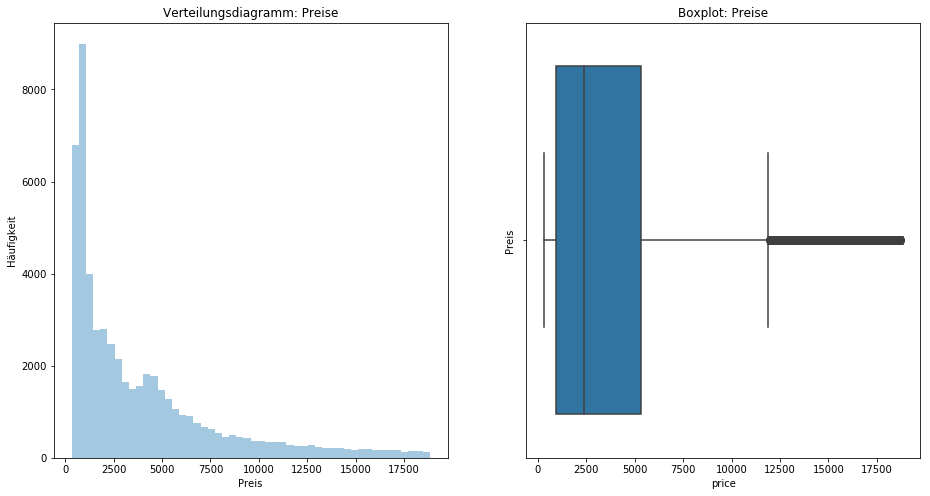

In [10]:
print("Zusammenfassung:")
print(data["price"].describe())

print("\nAusreißer: ", len(data[data.price > 11885]), "\n")

fig, (ax1,ax2) = plt.subplots(2,2, figsize=(24,8)) 

#Distplot
plt.subplot(1,3,1)
sns.distplot(data['price'], kde = False, bins = 50)
plt.xlabel('Preis')
plt.ylabel('Häufigkeit')
plt.title('Verteilungsdiagramm: Preise')

#Boxplot
plt.subplot(1,3,2)
sns.boxplot(data['price'])
plt.ylabel('Preis')
plt.title('Boxplot: Preise')

plt.show()

### Feature: carat

Das Gewicht von Diamanten wird in Karat gemessen. Ein Karat entspricht 0,2 Gramm. Generell sind schwerere Diamanten aufgrund ihrer Seltenheit überproportional teurer[[16]](#karat).
<br>Skala: metrisch/verhältnisskaliert

Beobachtung
* Rechtsschiefe Verteilung
* Ausreißer: Nach IQR-Methode ab 1,9 -> insgesamt 2.196 Ausreißer
* Positiver Zusammenhang zum Preis erkennbar

Fazit:
* Preis und Karat korrelieren
* Ausreißer sollten entfernt werden

Zusammenfassung:
count    53940.000000
mean         0.797940
std          0.474011
min          0.200000
25%          0.400000
50%          0.700000
75%          1.040000
max          5.010000
Name: carat, dtype: float64

Ausreißer:  2196

Korrelationskoeffizienten:
Spearman: 0.9628827988813001 	p-Wert:  0.0
Pearson:  0.9215913011935009 	p-Wert:  0.0





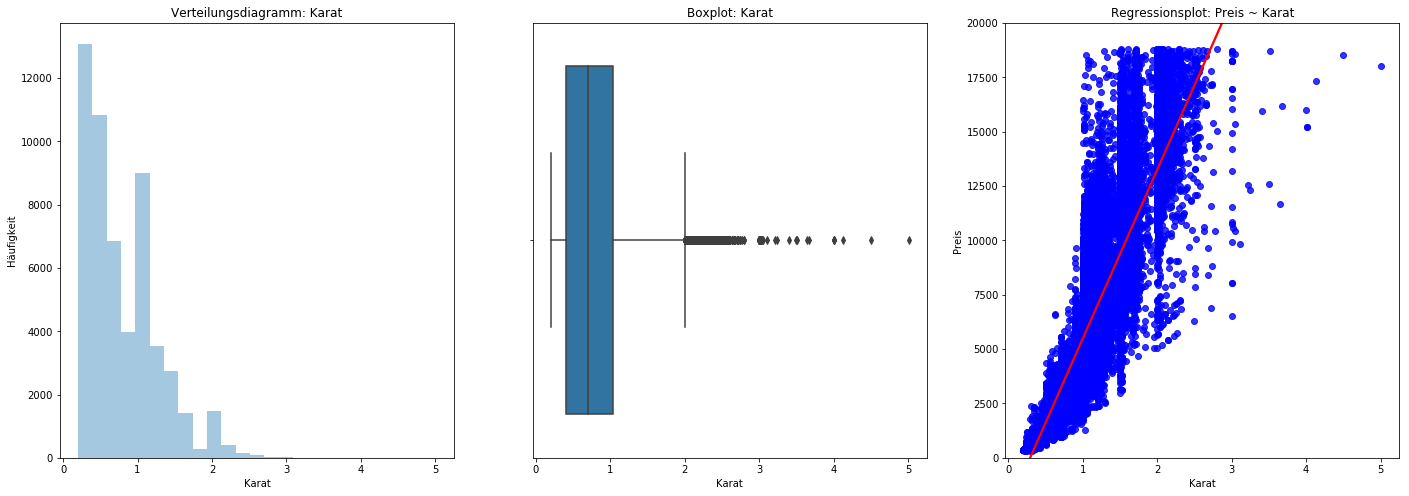

In [12]:
print("Zusammenfassung:")
print(data["carat"].describe())

print("\nAusreißer: ", len(data[data.carat > 1.9]))

print("\nKorrelationskoeffizienten:")

spearman = scipy.stats.spearmanr(data['carat'], data['price'])
pearson = scipy.stats.pearsonr(data['carat'], data['price'])

print("Spearman:", spearman.correlation, "\tp-Wert: ", spearman.pvalue)
print("Pearson: ", pearson[0], "\tp-Wert: ", pearson[1])

print("\n\n")

fig, (ax1,ax2) = plt.subplots(2,2, figsize=(24,8)) 

#Distplot
plt.subplot(1,3,1)
sns.distplot(data['carat'], kde = False, bins = 25)
plt.xlabel('Karat')
plt.ylabel('Häufigkeit')
plt.title('Verteilungsdiagramm: Karat')

#Boxplot
plt.subplot(1,3,2)
sns.boxplot(data['carat'])
plt.xlabel('Karat')
plt.title('Boxplot: Karat')

#Regplot
plt.subplot(1,3,3)
sns.regplot(x = 'carat', y = 'price', data = data, scatter_kws = {'color': 'blue'}, line_kws = {'color': 'red'})
plt.ylim(0,20000)
plt.xlabel('Karat')
plt.ylabel('Preis')
plt.title('Regressionsplot: Preis ~ Karat')

plt.show()

[Marker für Präsentation: Zu Pairplots](#markerpairplots)

### Feature: cut

Der Schliff beeinflusst die Lichtbrechung und damit das Funkeln bzw. das sogenannte „Feuer“ des Diamanten. Je besser der Schnitt, desto besser scheint und funkelt der Diamant und desto hochwertiger und ist er[[17]](#schliff). Die Reihenfolge der Merkmalsausprägungen ist absteigend sortiert[[18]](#schliffreihenfolge):
<br>Ideal
<br>Premium
<br>Very Good
<br>Good
<br>Fair

<br>Skala: kategorial/ordinalskaliert

Beobachtung
* Ungleiche Verteilung
* Ausreißer in jeder Gruppe nach oben
* Preis steigt mit abnehmender Qualität

Fazit:
* Preis und Schliff scheinen nicht wie erwartet zu korrelieren, genauere Prüfung notwendig
* Möglicherweise sind Diamanten mit hochwertigen Schliff kleiner, was den Preis dann wieder mindert

Zusammenfassung:
count     53940
unique        5
top       Ideal
freq      21551
Name: cut, dtype: object

Varianzanalyse:
p-Wert:  8.42830730759452e-150





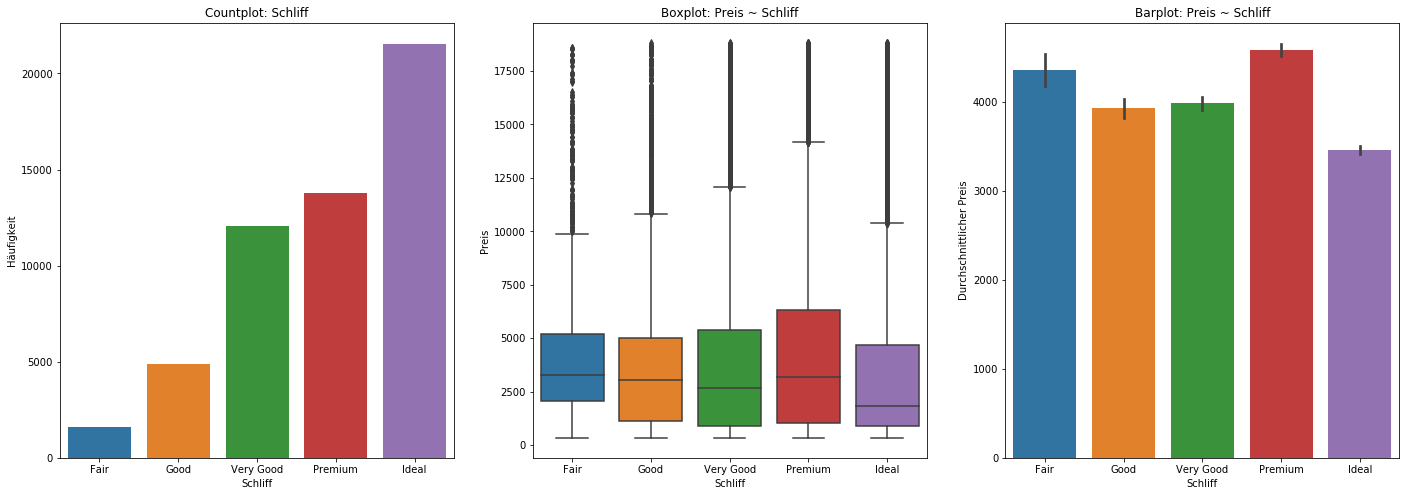

In [15]:
print("Zusammenfassung:")
print(data["cut"].describe())

print("\nVarianzanalyse:")

anova = scipy.stats.f_oneway(data['price'][data['cut'] == 'Ideal'],
                             data['price'][data['cut'] == 'Premium'],
                             data['price'][data['cut'] == 'Very Good'],
                             data['price'][data['cut'] == 'Good'],
                             data['price'][data['cut'] == 'Fair'])

print("p-Wert: ", anova.pvalue)

print("\n\n")

fig, (ax1,ax2) = plt.subplots(2,2, figsize=(24,8)) 

#Countplot
plt.subplot(1,3,1)
sns.countplot(x = data['cut'], order = ["Fair","Good","Very Good","Premium","Ideal"])
plt.xlabel('Schliff')
plt.ylabel('Häufigkeit')
plt.title('Countplot: Schliff')

#Boxplot
plt.subplot(1,3,2)
sns.boxplot(x = data['cut'], y = data['price'], order = ["Fair","Good","Very Good","Premium","Ideal"])
plt.xlabel('Schliff')
plt.ylabel('Preis')
plt.title('Boxplot: Preis ~ Schliff')

#Verteilung
plt.subplot(1,3,3)
sns.barplot(x = data['cut'], y = data['price'], order = ["Fair","Good","Very Good","Premium","Ideal"])
plt.xlabel('Schliff')
plt.ylabel('Durchschnittlicher Preis')
plt.title('Barplot: Preis ~ Schliff')

plt.show()

### Feature: color
Die Farbe des Diamanten richtet sich nach der Klarheit. Je klarer und durchsichtiger der Diamant ist, desto hochwertiger ist der Diamant. Leichte, meist gelbliche Verfärbungen mindern die Qualität. Die Reihenfolge der Merkmalsausprägungen ist absteigend sortiert[[19]](#farbe):
<br>D
<br>E
<br>F
<br>G
<br>H
<br>I
<br>J

![title](farbe.png)

<br>Skala: kategorial/ordinalskaliert

Beobachtung
* Ungleiche Verteilung
* Ausreißer in jeder Gruppe nach oben
* Preis steigt mit abnehmender Qualität

Fazit:
* Preis und Farbe scheinen nicht wie erwartet zu korrelieren, genauere Prüfung notwendig
* Geringerer Preis bei besserer Farbe kann durch andere Qualitätsmängel begründet sein


Zusammenfassung:
count     53940
unique        7
top           G
freq      11292
Name: color, dtype: object

Varianzanalyse:
p-Wert:  0.0





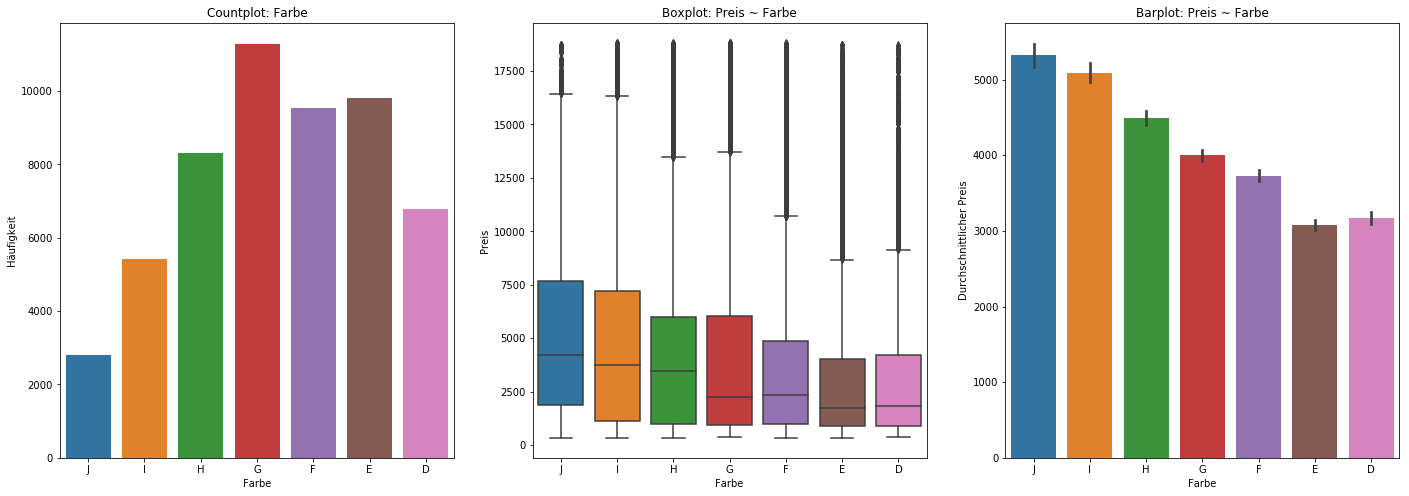

In [14]:
print("Zusammenfassung:")
print(data["color"].describe())

print("\nVarianzanalyse:")

anova = scipy.stats.f_oneway(data['price'][data['color'] == 'D'],
                             data['price'][data['color'] == 'E'],
                             data['price'][data['color'] == 'F'],
                             data['price'][data['color'] == 'G'],
                             data['price'][data['color'] == 'H'],
                             data['price'][data['color'] == 'I'],
                             data['price'][data['color'] == 'J'])

print("p-Wert: ", anova.pvalue)

print("\n\n")

fig, (ax1,ax2) = plt.subplots(2,2, figsize=(24,8)) 

#Countplot
plt.subplot(1,3,1)
sns.countplot(x = data['color'], order = ["J","I","H","G","F","E","D"])
plt.xlabel('Farbe')
plt.ylabel('Häufigkeit')
plt.title('Countplot: Farbe')

#Boxplot
plt.subplot(1,3,2)
sns.boxplot(x = data['color'], y = data['price'], order = ["J","I","H","G","F","E","D"])
plt.xlabel('Farbe')
plt.ylabel('Preis')
plt.title('Boxplot: Preis ~ Farbe')

#Verteilung
plt.subplot(1,3,3)
sns.barplot(x = data['color'], y = data['price'], order = ["J","I","H","G","F","E","D"])
plt.xlabel('Farbe')
plt.ylabel('Durchschnittlicher Preis')
plt.title('Barplot: Preis ~ Farbe')

plt.show()

### Feature: clarity
Die Reinheit des Diamanten gibt an, wie durchsichtig der Diamant ist. Risse oder Verunreinigungen durch andere Mineralien können die Durchsichtigkeit bzw. die Reinheit und damit die Qualität mindern. Die Reihenfolge der Merkmalsausprägungen ist absteigend sortiert[[20]](#reinheit):
<br>IF    (internally flawless)
<br>VSS1  (very, very small inclusions 1)
<br>VSS2  (very, very small inclusions 2)
<br>VS1   (very small inclusions 1)
<br>VS2   (very small inclusions 2)
<br>SI1   (small inclusions 1)
<br>SI2   (small inclusions 2)
<br>I1    (inclusions 1)

<br>Skala: kategorial/ordinalskaliert

Beobachtung
* Ungleiche Verteilung
* Ausreißer in jeder Gruppe nach oben
* Preis steigt mit abnehmender Qualität

Fazit: 
* Preis und Reinheit scheinen nicht wie erwartet zu korrelieren, genauere Prüfung notwendig
* Geringerer Preis bei besserer Farbe kann durch andere Qualitätsmängel begründet sein


Zusammenfassung:
count     53940
unique        8
top         SI1
freq      13065
Name: clarity, dtype: object

Varianzanalyse:
p-Wert:  1.9190895e-316





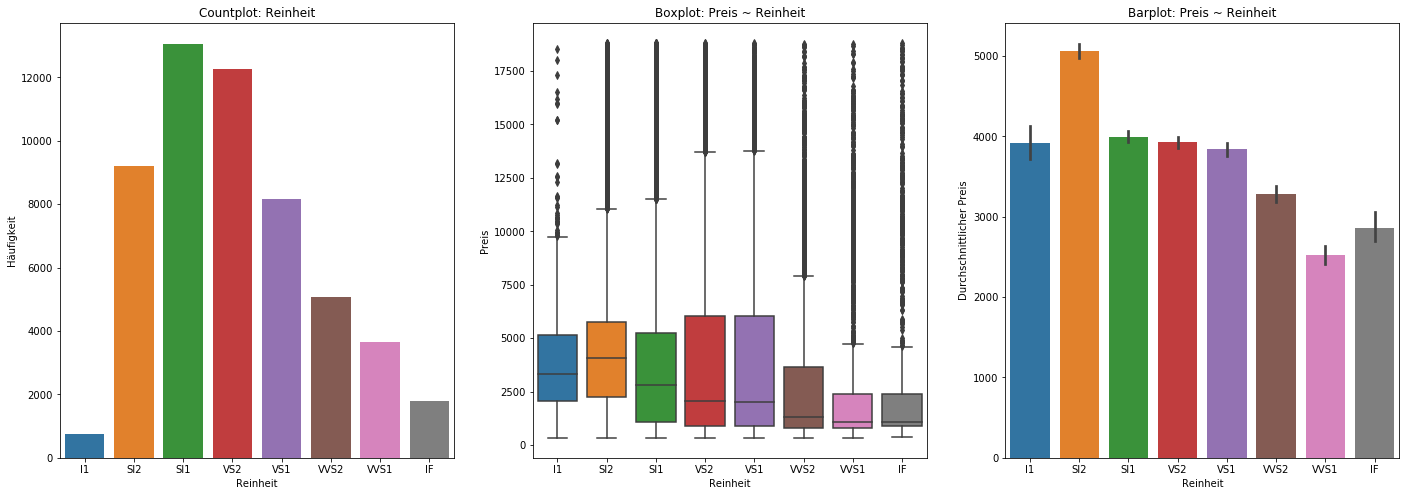

In [16]:
print("Zusammenfassung:")
print(data["clarity"].describe())

print("\nVarianzanalyse:")

anova = scipy.stats.f_oneway(data['price'][data['clarity'] == 'IF'],
                             data['price'][data['clarity'] == 'VVS1'],
                             data['price'][data['clarity'] == 'VVS2'],
                             data['price'][data['clarity'] == 'VS1'],
                             data['price'][data['clarity'] == 'VS2'],
                             data['price'][data['clarity'] == 'SI1'],
                             data['price'][data['clarity'] == 'SI2'],
                             data['price'][data['clarity'] == 'I1'])

print("p-Wert: ", anova.pvalue)

print("\n\n")

fig, (ax1,ax2) = plt.subplots(2,2, figsize=(24,8)) 

#Countplot
plt.subplot(1,3,1)
sns.countplot(x = data['clarity'], order = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"])
plt.xlabel('Reinheit')
plt.ylabel('Häufigkeit')
plt.title('Countplot: Reinheit')

#Boxplot
plt.subplot(1,3,2)
sns.boxplot(x = data['clarity'], y = data['price'], order = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"])
plt.xlabel('Reinheit')
plt.ylabel('Preis')
plt.title('Boxplot: Preis ~ Reinheit')

#Verteilung
plt.subplot(1,3,3)
sns.barplot(x = data['clarity'], y = data['price'], order = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"])
plt.xlabel('Reinheit')
plt.ylabel('Durchschnittlicher Preis')
plt.title('Barplot: Preis ~ Reinheit')

plt.show()

### Feature: x
Die Länge des Diamanten wird in Millimetern angegeben.
<br>Skala: metrisch/verhältnisskaliert

Beobachtung
* Annähernde Normalverteilung
* Ausreißer: Nach IQR-Methode unter ~2,0 und über ~9,3 -> insgesamt 32 Ausreißer
* Minimum ist 0, muss aber > 0 sein, daher sind offensichtlich falsche Datensätze enthalten
* Positiver Zusammenhang zum Preis erkennbar

Fazit:
* Preis und Länge korrelieren
* Ausreißer sollten eventuell entfernt werden, falsche Datensätze müssen entfernt werden


Zusammenfassung:
count    53940.000000
mean         5.731157
std          1.121761
min          0.000000
25%          4.710000
50%          5.700000
75%          6.540000
max         10.740000
Name: x, dtype: float64

Ausreißer:  32

Korrelationskoeffizienten:
Spearman: 0.9631961087113347 	p-Wert:  0.0
Pearson:  0.8844351610161139 	p:Wert:  0.0





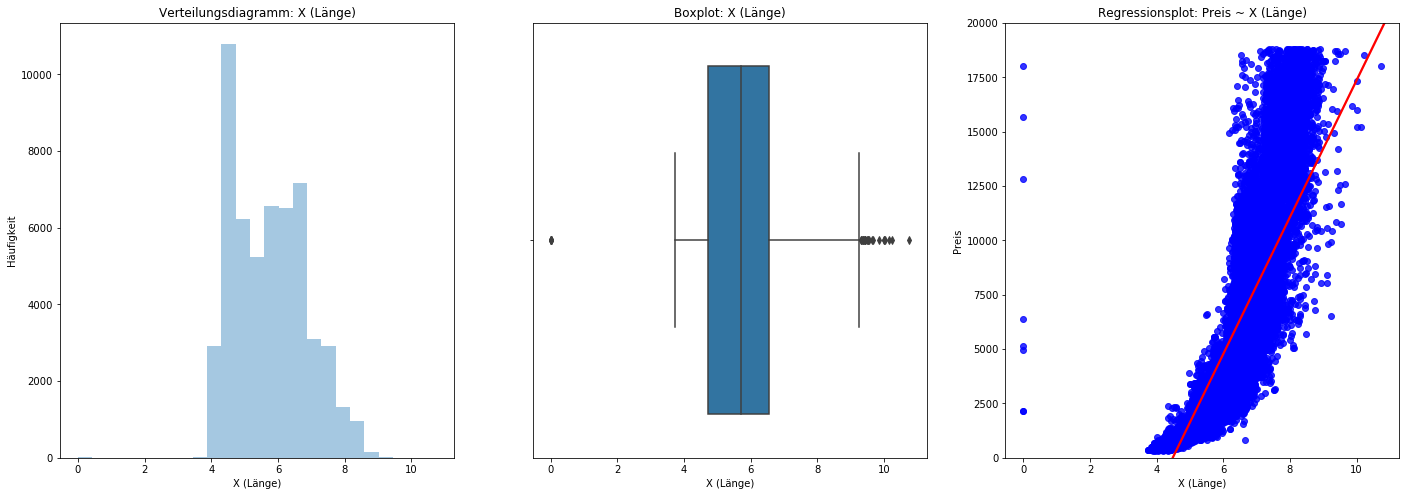

In [18]:
print("Zusammenfassung:")
print(data["x"].describe())

print("\nAusreißer: ", (len(data[data.x > 9.285])+ len(data[data.x < 1.965])))

print("\nKorrelationskoeffizienten:")

spearman = scipy.stats.spearmanr(data['x'], data['price'])
pearson = scipy.stats.pearsonr(data['x'], data['price'])

print("Spearman:", spearman.correlation, "\tp-Wert: ", spearman.pvalue)
print("Pearson: ", pearson[0], "\tp:Wert: ", pearson[1])

print("\n\n")

fig, (ax1,ax2) = plt.subplots(2,2, figsize=(24,8)) 

#Distplot
plt.subplot(1,3,1)
sns.distplot(data['x'], kde = False, bins = 25)
plt.xlabel('X (Länge)')
plt.ylabel('Häufigkeit')
plt.title('Verteilungsdiagramm: X (Länge)')

#Boxplot
plt.subplot(1,3,2)
sns.boxplot(data['x'])
plt.xlabel('X (Länge)')
plt.title('Boxplot: X (Länge)')

#Regplot
plt.subplot(1,3,3)
sns.regplot(x = 'x', y = 'price', data = data, scatter_kws = {'color': 'blue'}, line_kws = {'color': 'red'})
plt.ylim(0,20000)
plt.xlabel('X (Länge)')
plt.ylabel('Preis')
plt.title('Regressionsplot: Preis ~ X (Länge)')

plt.show()

### Feature: y
Die Breite des Diamanten in Millimetern angegeben.
<br>Skala: mertisch/verhältnisskaliert

 Beobachtung
* Rechtsschiefe Verteilung (ohne Ausreißer eher normalverteilt)
* Ausreißer: Nach IQR-Methode unter ~2,0 und über ~9,3 -> insgesamt 29 Ausreißer
* Minimum ist 0, muss aber > 0 sein, daher sind offensichtlich falsche Datensätze enthalten
* Positiver Zusammenhang zum Preis erkennbar
* Die Ausreißer mindern die Aussagekraft der Diagramme

Fazit:
* Preis und Breite korrelieren
* Ausreißer sollten entfernt werden (vielleicht erst ab 12 mm), falsche Datensätze müssen entfernt werden


Zusammenfassung:
count    53940.000000
mean         5.734526
std          1.142135
min          0.000000
25%          4.720000
50%          5.710000
75%          6.540000
max         58.900000
Name: y, dtype: float64

Ausreißer:  29

Korrelationskoeffizienten:
Spearman: 0.9627188193892315 	p-Wert:  0.0
Pearson:  0.8654208978641903 	p-Wert:  0.0





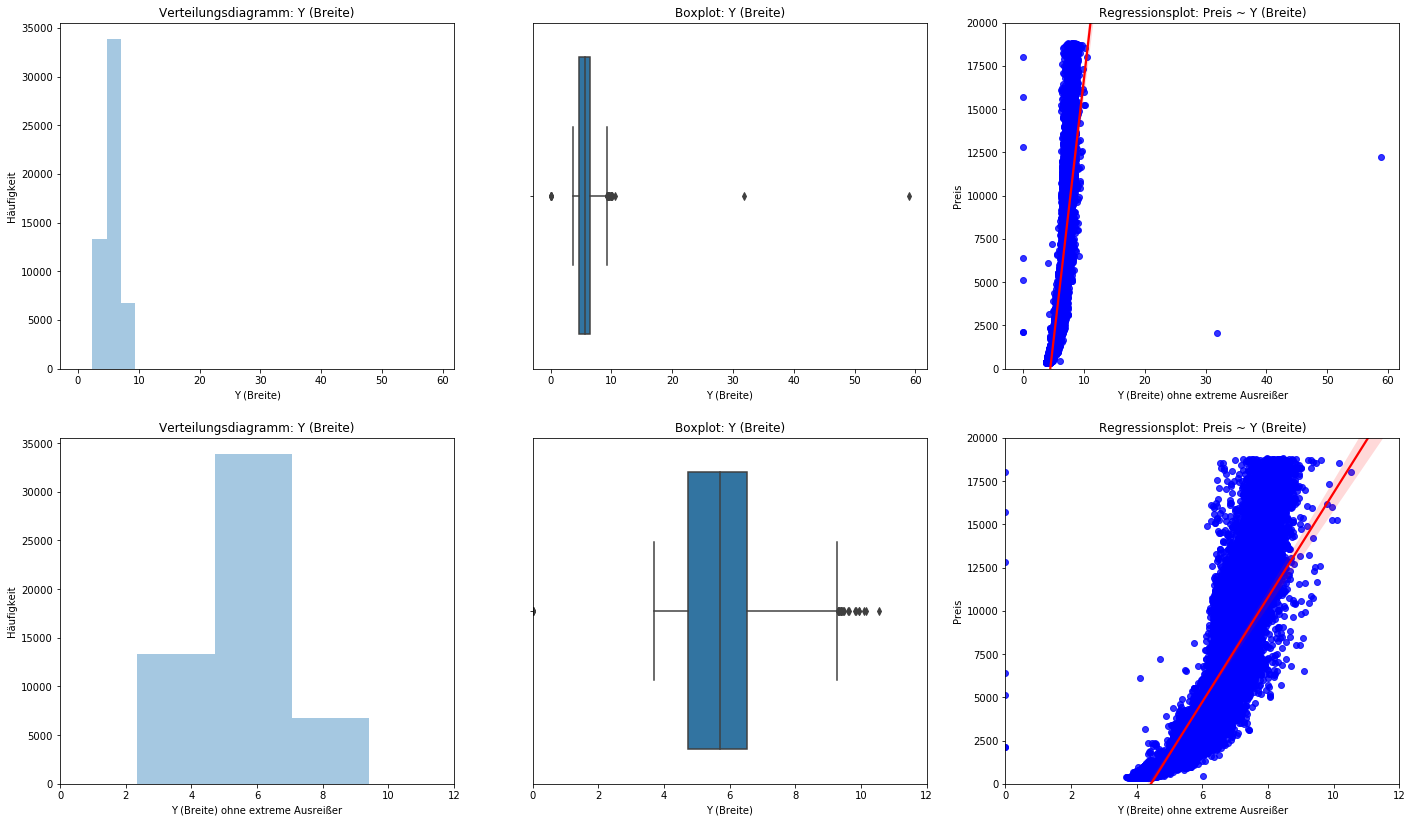

In [35]:
print("Zusammenfassung:")
print(data["y"].describe())

print("\nAusreißer: ", (len(data[data.y > 9.27])+ len(data[data.y < 2.01])))

print("\nKorrelationskoeffizienten:")

spearman = scipy.stats.spearmanr(data['y'], data['price'])
pearson = scipy.stats.pearsonr(data['y'], data['price'])

print("Spearman:", spearman.correlation, "\tp-Wert: ", spearman.pvalue)
print("Pearson: ", pearson[0], "\tp-Wert: ", pearson[1])

print("\n\n")

fig, (ax1,ax2) = plt.subplots(2,3, figsize=(24,14)) 

#Distplot
plt.subplot(2,3,1)
sns.distplot(data['y'], kde = False, bins = 25)
plt.xlabel('Y (Breite)')
plt.ylabel('Häufigkeit')
plt.title('Verteilungsdiagramm: Y (Breite)')

#Boxplot
plt.subplot(2,3,2)
sns.boxplot(data['y'])
plt.xlabel('Y (Breite)')
plt.title('Boxplot: Y (Breite)')

#Regplot
plt.subplot(2,3,3)
sns.regplot(x = 'y', y = 'price', data = data, scatter_kws = {'color': 'blue'}, line_kws = {'color': 'red'})
plt.ylim(0,20000)
plt.xlabel('Y (Breite) ohne extreme Ausreißer')
plt.ylabel('Preis')
plt.title('Regressionsplot: Preis ~ Y (Breite)')

#Ohne extreme Ausreißer nach oben

#Distplot
plt.subplot(2,3,4)
sns.distplot(data['y'], kde = False, bins = 25)
plt.xlabel('Y (Breite) ohne extreme Ausreißer')
plt.ylabel('Häufigkeit')
plt.xlim(0,12)
plt.title('Verteilungsdiagramm: Y (Breite)')

#Boxplot
plt.subplot(2,3,5)
sns.boxplot(data['y'])
plt.xlabel('Y (Breite)')
plt.xlim(0,12)
plt.title('Boxplot: Y (Breite)')

#Regplot
plt.subplot(2,3,6)
sns.regplot(x = 'y', y = 'price', data = data, scatter_kws = {'color': 'blue'}, line_kws = {'color': 'red'})
plt.ylim(0,20000)
plt.xlim(0,12)
plt.xlabel('Y (Breite) ohne extreme Ausreißer')
plt.ylabel('Preis')
plt.title('Regressionsplot: Preis ~ Y (Breite)')

plt.show()

### Feature: z
Die Höhe des Diamanten wird in Millimetern angegeben
<br>Skala: mertisch/verhältnisskaliert

Beobachtung
* Rechtsschiefe Verteilung (ohne Ausreißer eher normalverteilt)
* Ausreißer: Nach IQR-Methode unter ~1,2 und über ~5,7 -> insgesamt 49 Ausreißer
* Minimum ist 0, muss aber > 0 sein, daher sind offensichtlich falsche Datensätze enthalten
* Positiver Zusammenhang zum Preis erkennbar

Fazit:
* Preis und Höhe korrelieren
* Ausreißer sollten entfernt werden (vielleicht erst ab 8 mm), falsche Datensätze müssen entfernt werden


Zusammenfassung:
count    53940.000000
mean         3.538734
std          0.705699
min          0.000000
25%          2.910000
50%          3.530000
75%          4.040000
max         31.800000
Name: z, dtype: float64

Ausreißer:  49

Korrelationskoeffizienten:
Spearman: 0.9572322686120686 	p-Wert:  0.0
Pearson:  0.861249443851434 	p-Wert:  0.0





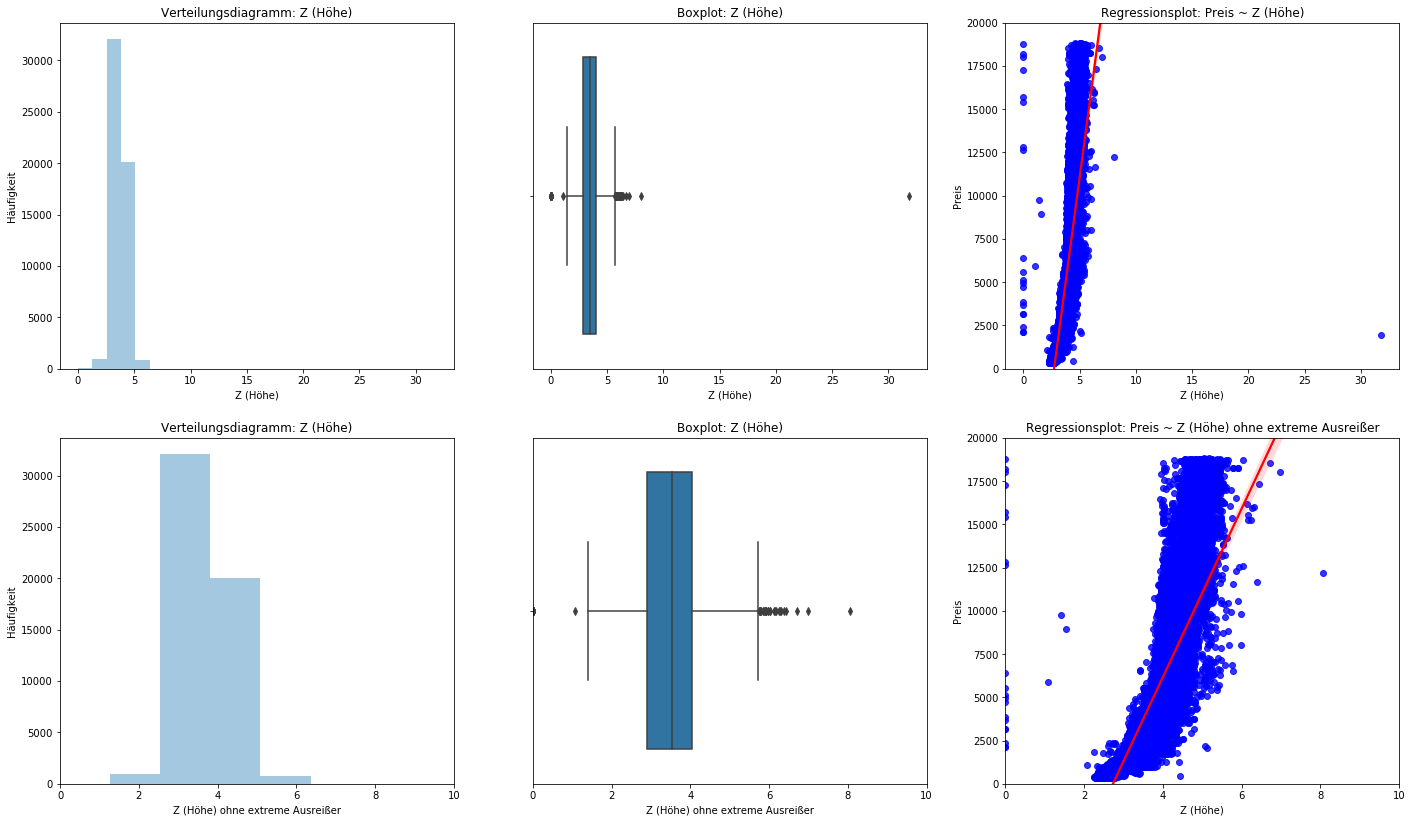

In [33]:
print("Zusammenfassung:")
print(data["z"].describe())

print("\nAusreißer: ", (len(data[data.z > 5.735])+ len(data[data.z < 1.215])))

print("\nKorrelationskoeffizienten:")

spearman = scipy.stats.spearmanr(data['z'], data['price'])
pearson = scipy.stats.pearsonr(data['z'], data['price'])

print("Spearman:", spearman.correlation, "\tp-Wert: ", spearman.pvalue)
print("Pearson: ", pearson[0], "\tp-Wert: ", pearson[1])

print("\n\n")

fig, (ax1,ax2) = plt.subplots(2,3, figsize=(24,14)) 

#Distplot
plt.subplot(2,3,1)
sns.distplot(data['z'], kde = False, bins = 25)
plt.xlabel('Z (Höhe)')
plt.ylabel('Häufigkeit')
plt.title('Verteilungsdiagramm: Z (Höhe)')

#Boxplot
plt.subplot(2,3,2)
sns.boxplot(data['z'])
plt.xlabel('Z (Höhe)')
plt.title('Boxplot: Z (Höhe)')

#Regplot
plt.subplot(2,3,3)
sns.regplot(x = 'z', y = 'price', data = data, scatter_kws = {'color': 'blue'}, line_kws = {'color': 'red'})
plt.ylim(0,20000)
plt.xlabel('Z (Höhe)')
plt.ylabel('Preis')
plt.title('Regressionsplot: Preis ~ Z (Höhe)')

#Ohne extreme Ausreißer nach oben

#Distplot
plt.subplot(2,3,4)
sns.distplot(data['z'], kde = False, bins = 25)
plt.xlabel('Z (Höhe) ohne extreme Ausreißer')
plt.ylabel('Häufigkeit')
plt.xlim(0,10)
plt.title('Verteilungsdiagramm: Z (Höhe)')

#Boxplot
plt.subplot(2,3,5)
sns.boxplot(data['z'])
plt.xlabel('Z (Höhe) ohne extreme Ausreißer')
plt.xlim(0,10)
plt.title('Boxplot: Z (Höhe)')

#Regplot
plt.subplot(2,3,6)
sns.regplot(x = 'z', y = 'price', data = data, scatter_kws = {'color': 'blue'}, line_kws = {'color': 'red'})
plt.ylim(0,20000)
plt.xlabel('Z (Höhe)')
plt.ylabel('Preis')
plt.xlim(0,10)
plt.title('Regressionsplot: Preis ~ Z (Höhe) ohne extreme Ausreißer')

plt.show()

### Feature: depth
Die Tiefe des Diamanten ergibt sich aus dem Anteil des Pavillons an der Höhe (z), hier als prozentualer Anteil angegeben.
<br>Skala: metrisch/verhältnisskaliert

Beobachtung
* normalverteilt
* Ausreißer: Nach IQR-Methode unter ~59 und über ~65 -> insgesamt 2.545 Ausreißer
* Kein Zusammenhang erkennbar

Fazit:
* Preis und Tiefe korrelieren nicht direkt sichtbar
* Kann möglicherweise aus Daten entfernt werden

Zusammenfassung:
count    53940.000000
mean        61.749405
std          1.432621
min         43.000000
25%         61.000000
50%         61.800000
75%         62.500000
max         79.000000
Name: depth, dtype: float64

Ausreißer:  2545

Korrelationskoeffizienten:
Spearman: 0.01001966963455154 		p-Wert:  0.019961465178476374
Pearson:  -0.010647404584142647 	p:Wert:  0.013403249011912978





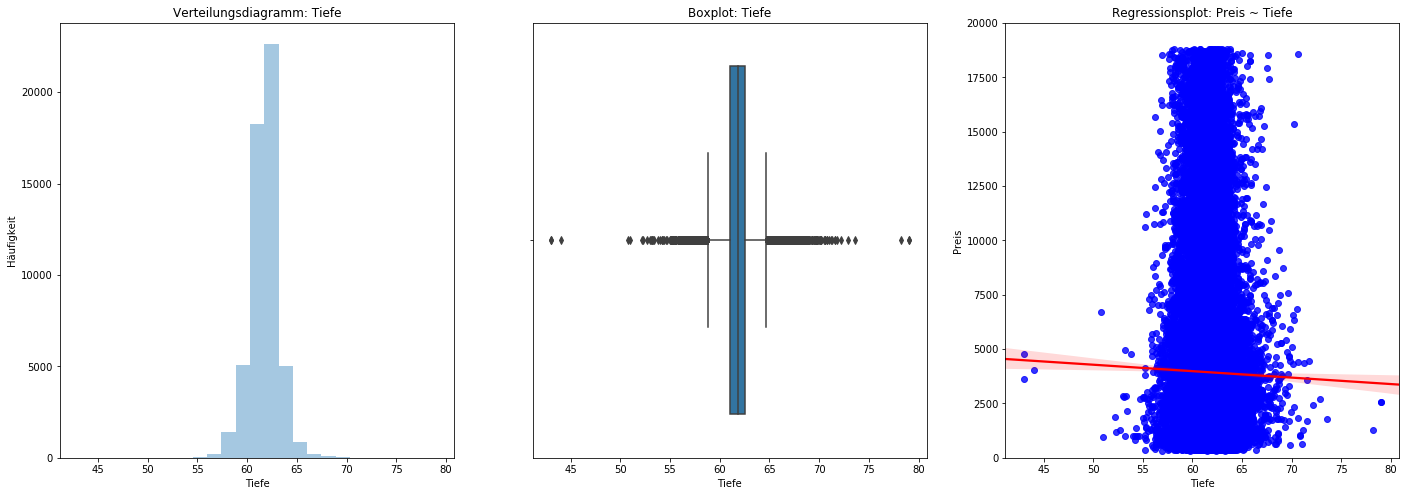

In [25]:
print("Zusammenfassung:")
print(data["depth"].describe())

print("\nAusreißer: ", (len(data[data.depth > 64.75])+ len(data[data.depth < 58.75])))

print("\nKorrelationskoeffizienten:")

spearman = scipy.stats.spearmanr(data['depth'], data['price'])
pearson = scipy.stats.pearsonr(data['depth'], data['price'])

print("Spearman:", spearman.correlation, "\t\tp-Wert: ", spearman.pvalue)
print("Pearson: ", pearson[0], "\tp-Wert: ", pearson[1])

print("\n\n")

fig, (ax1,ax2) = plt.subplots(2,2, figsize=(24,8)) 

#Distplot
plt.subplot(1,3,1)
sns.distplot(data['depth'], kde = False, bins = 25)
plt.xlabel('Tiefe')
plt.ylabel('Häufigkeit')
plt.title('Verteilungsdiagramm: Tiefe')

#Boxplot
plt.subplot(1,3,2)
sns.boxplot(data['depth'])
plt.xlabel('Tiefe')
plt.title('Boxplot: Tiefe')

#Regplot
plt.subplot(1,3,3)
sns.regplot(x = 'depth', y = 'price', data = data, scatter_kws = {'color': 'blue'}, line_kws = {'color': 'red'})
plt.ylim(0,20000)
plt.xlabel('Tiefe')
plt.ylabel('Preis')
plt.title('Regressionsplot: Preis ~ Tiefe')

plt.show()

### Feature: table
Die obere Fläche der Krone wird als Tisch bezeichnet. In den Daten wird der Tisch als prozentualer Anteil der Länge (x) angegeben.
<br>Skala: metrisch/verhältnisskaliert

Beobachtung
* normalverteilt/leicht rechtsschief
* Ausreißer: Nach IQR-Methode unter ~53 und über ~62 -> insgesamt 22.438 Ausreißer
* Kein Zusammenhang erkennbar

Fazit:
* Preis und Tisch korrelieren nicht direkt sichtbar
* Kann möglicherweise aus Daten entfernt werden

Zusammenfassung:
count    53940.000000
mean        57.457184
std          2.234491
min         43.000000
25%         56.000000
50%         57.000000
75%         59.000000
max         95.000000
Name: table, dtype: float64

Ausreißer:  22438

Korrelationskoeffizienten:
Spearman: 0.17178447793764812 	p-Wert:  0.0
Pearson:  0.1271339021217424 	p:Wert:  3.761533913245548e-193





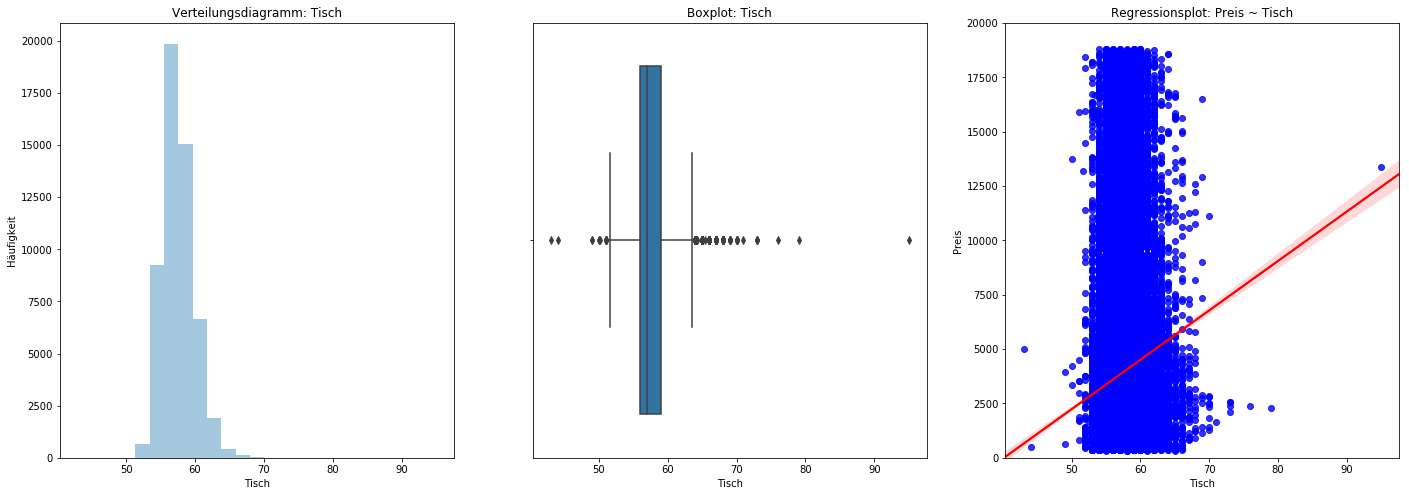

In [27]:
print("Zusammenfassung:")
print(data["table"].describe())

print("\nAusreißer: ", (len(data[data.depth > 62])+ len(data[data.depth < 53])))

print("\nKorrelationskoeffizienten:")

spearman = scipy.stats.spearmanr(data['table'], data['price'])
pearson = scipy.stats.pearsonr(data['table'], data['price'])

print("Spearman:", spearman.correlation, "\tp-Wert: ", spearman.pvalue)
print("Pearson: ", pearson[0], "\tp-Wert: ", pearson[1])

print("\n\n")

fig, (ax1,ax2) = plt.subplots(2,2, figsize=(24,8)) 

#Distplot
plt.subplot(1,3,1)
sns.distplot(data['table'], kde = False, bins = 25)
plt.xlabel('Tisch')
plt.ylabel('Häufigkeit')
plt.title('Verteilungsdiagramm: Tisch')

#Boxplot
plt.subplot(1,3,2)
sns.boxplot(data['table'])
plt.xlabel('Tisch')
plt.title('Boxplot: Tisch')

#Regplot
plt.subplot(1,3,3)
sns.regplot(x = 'table', y = 'price', data = data, scatter_kws = {'color': 'blue'}, line_kws = {'color': 'red'})
plt.ylim(0,20000)
plt.xlabel('Tisch')
plt.ylabel('Preis')
plt.title('Regressionsplot: Preis ~ Tisch')

plt.show()

### Fazit der univarianten Analyse der einzelnen Merkmale
Die Merkmale carat, x, y und z beeinflussen den Preis der Diamanten positiv. Das ist zu erwarten, da das Gewicht bzw. die Größe stark zusammenhängen und als wichtigstes Merkmal für die Bestimmung des Preises gelten.
Bei der ersten Analyse fällt allerdings auf, dass qualitativ hochwertigere Merkmalsausprägungen bei den Merkmalen cut, color und clarity anscheinend einen negativen Einfluss auf den Preis der Diamanten haben. Dieser Sachverhalt entspricht nicht der Erwartung und der Recherche und muss daher genauer analysiert werden.

Die Merkmale table und depth sollten keinen oder nur sehr geringen Einfluss auf den Preis haben, was sich auch in den Daten wiederspiegelt. Daher werden diese beiden Merkmale nicht weiter betrachtet und aus den Daten entfernt.

Bei den Merkmalen x, y und z müssen einige falsche Datensätze sowie die mit der IQR-Methode berechneten Ausreißer entfernt werden. 
Um nicht zu viele Datensätze zu entfernen, werden die Datensätze folgerdermaßen bereinigt:
Bei dem Merkmal Karat werden Ausreißer mit einem Wert von über 2,0 entfernt. 
Bei dem Merkmal Tiefe werden Ausreißer mit einem Wert von unter 50 und über 70 entfernt. 
Bei dem Merkmal Tisch werden Ausreißer mit einem Wert von unter 53 und über 65 entfernt.
Damit werden dann insgesamt 2.170 Datensätze entfernt.

In [9]:
initialLenght = len(data)

#Falsche Daten und Ausreißer aus x, y und z entfernen
data = data[data['x'] > 1.965]
data = data[data['x'] < 9.285]
data = data[data['y'] > 2.01]
data = data[data['y'] < 9.27]
data = data[data['z'] > 1.215]
data = data[data['z'] < 5.735]

#Ausreißer aus Karat entfernen (größer als 2,0)
data = data[data['carat'] <= 2.0]

#Ausreißer aus Tiefe entfernen (größer als 70 und kleiner als 50)
data = data[data['depth'] <= 70]
data = data[data['depth'] >= 50]

#Ausreißer aus Tisch entfernen (größer als 65 und kleiner als 53)
data = data[data['table'] <= 65]
data = data[data['table'] >= 53]

print(initialLenght, "Datensätze vor Bereinigung")
print("", initialLenght - len(data), "Datensätze entfernt")
print(len(data), "Datensätze nach Bereinigung\n")

53940 Datensätze vor Bereinigung
 2170 Datensätze entfernt
51770 Datensätze nach Bereinigung



### Unerwartete negative Korrelation von Farbe, Schliff und Reinheit mit Preis

Aus der bisherigen Analyse hat sich ergeben, dass sich höherwertige Merkmalsausprägungen der Merkmale Farbe, Schliff und Preis negativ auf den Preis auszuwirken scheinen. Es werden daher zwei Annahmen untersucht, die diesen unterwarteten Zusammenhang erklären könnten.

Das wichtigste Kriterium bei der Bestimmung des Preises eines Diamanten ist das Gewicht. Es ist möglich, dass ansonsten höherwertige Diamanten häufig ein sehr geringes Gewicht haben und dass schwere bzw. große Diamanten zwar niedrigere andere Qualitätsmerkmale aufweisen, diese mangelnde Qualität aber mit ihrem Gewicht so stark kompensieren, dass sie insgesamt teurer sind.

Andernfalls könnte eine mögliche Erklärung in der Verteilung der Daten liegt. Die Daten bzw. die Preise der Diamanten sind sehr ungleich verteilt. Es gibt wesentlich mehr Diamanten in den unteren Preissegmenten als in den oberen. Die Ungleichverteilung der Daten könnte die durchschnittlichen Preise der Merkmalsausprägungen verzerren.

Die Daten werden zunächst anhand des wichtigsten Merkmals (Karat) in die vier Quantile aufgeteilt. Danach werden die Merkmale Farbe, Schliff und Reinheit in den vier Quantilen separat auf die Verteilung und den Zusammenhang mit dem Preis untersucht.

In [8]:
print("Zusammenfassung:")
print(data["price"].describe())

Zusammenfassung:
count    51770.000000
mean      3531.642032
std       3415.692287
min        326.000000
25%        926.000000
50%       2282.000000
75%       4959.000000
max      18818.000000
Name: price, dtype: float64


In [5]:
#Aufteilung der Daten in Quantile
data_q1 = data[data["carat"] <= 0.39]

data_q2 = data[data["carat"] > 0.39]
data_q2 = data_q2[data_q2["carat"] <= 0.7]

data_q3 = data[data["carat"] > 0.7]
data_q3 = data_q3[data_q3["carat"] <= 1.02]

data_q4 = data[data["carat"] > 1.02]

print("Diamanten Quantil 1: ", len(data_q1))
print("Diamanten Quantil 2: ", len(data_q2))
print("Diamanten Quantil 3: ", len(data_q3))
print("Diamanten Quantil 4: ", len(data_q4))

Diamanten Quantil 1:  13092
Diamanten Quantil 2:  14070
Diamanten Quantil 3:  12401
Diamanten Quantil 4:  14377


Diamanten 1. Quantil


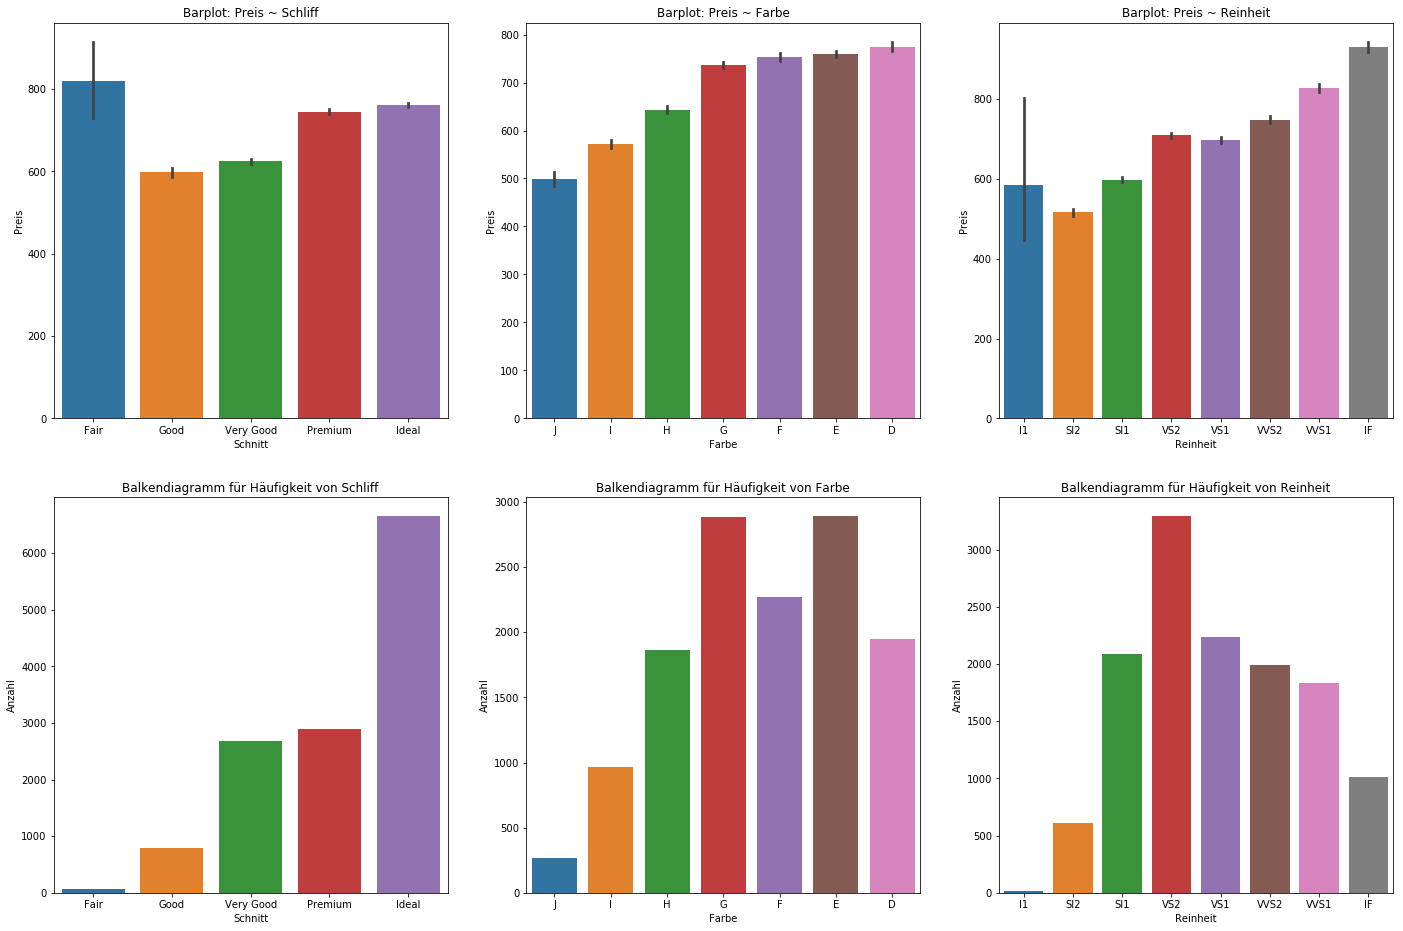

In [6]:
fig, (ax1,ax2) = plt.subplots(2,3, figsize=(24,16)) 

print("Diamanten 1. Quantil")

#Diagramme
plt.subplot(2,3,1)
sns.barplot(x = data_q1['cut'], y = data_q1['price'], order = ["Fair","Good","Very Good","Premium","Ideal"])
plt.xlabel("Schnitt")
plt.ylabel("Preis")
plt.title('Barplot: Preis ~ Schliff')

plt.subplot(2,3,2)
sns.barplot(x = data_q1['color'], y = data_q1['price'], order = ["J","I","H","G","F","E","D"])
plt.xlabel("Farbe")
plt.ylabel("Preis")
plt.title('Barplot: Preis ~ Farbe')

plt.subplot(2,3,3)
sns.barplot(x = data_q1['clarity'], y = data_q1['price'], order = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"])
plt.xlabel("Reinheit")
plt.ylabel("Preis")
plt.title('Barplot: Preis ~ Reinheit')

plt.subplot(2,3,4)
sns.countplot(x = data_q1['cut'], order = ["Fair","Good","Very Good","Premium","Ideal"])
plt.xlabel("Schliff")
plt.ylabel("Anzahl")
plt.title('Balkendiagramm für Häufigkeit von Schliff')

plt.subplot(2,3,5)
sns.countplot(x = data_q1['color'], order = ["J","I","H","G","F","E","D"])
plt.xlabel("Farbe")
plt.ylabel("Anzahl")
plt.title('Balkendiagramm für Häufigkeit von Farbe')

plt.subplot(2,3,6)
sns.countplot(x = data_q1['clarity'], order = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"])
plt.xlabel("Reinheit")
plt.ylabel("Anzahl")
plt.title('Balkendiagramm für Häufigkeit von Reinheit')

plt.show()

Diamanten 2. Quantil


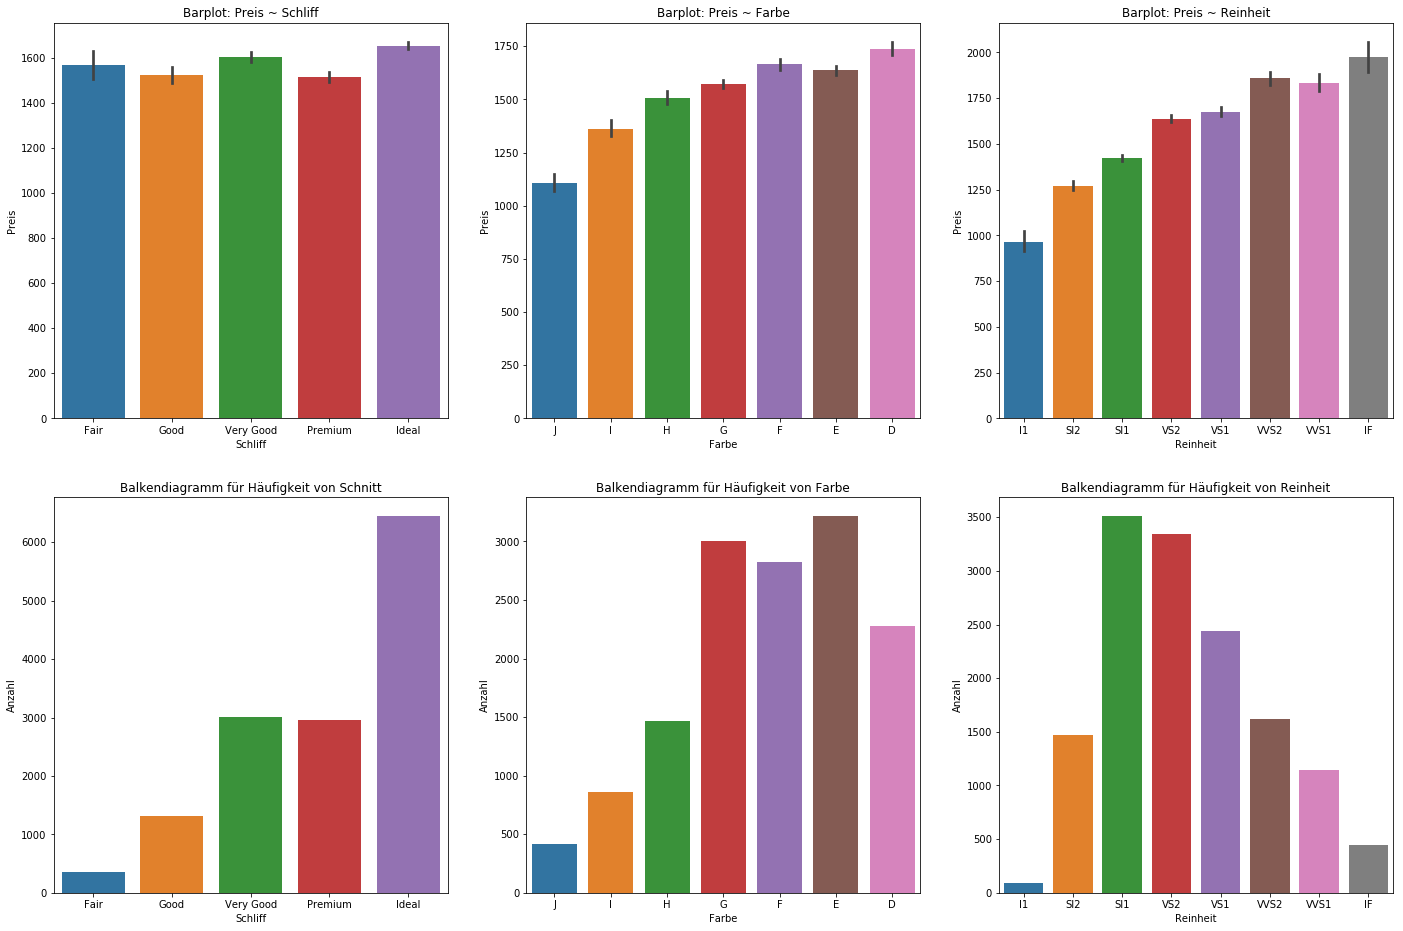

In [7]:
fig, (ax1,ax2) = plt.subplots(2,3, figsize=(24,16)) 

print("Diamanten 2. Quantil")

#Diagramme
plt.subplot(2,3,1)
sns.barplot(x = data_q2['cut'], y = data_q2['price'], order = ["Fair","Good","Very Good","Premium","Ideal"])
plt.xlabel("Schliff")
plt.ylabel("Preis")
plt.title('Barplot: Preis ~ Schliff')

plt.subplot(2,3,2)
sns.barplot(x = data_q2['color'], y = data_q2['price'], order = ["J","I","H","G","F","E","D"])
plt.xlabel("Farbe")
plt.ylabel("Preis")
plt.title('Barplot: Preis ~ Farbe')

plt.subplot(2,3,3)
sns.barplot(x = data_q2['clarity'], y = data_q2['price'], order = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"])
plt.xlabel("Reinheit")
plt.ylabel("Preis")
plt.title('Barplot: Preis ~ Reinheit')

plt.subplot(2,3,4)
sns.countplot(x = data_q2['cut'], order = ["Fair","Good","Very Good","Premium","Ideal"])
plt.xlabel("Schliff")
plt.ylabel("Anzahl")
plt.title('Balkendiagramm für Häufigkeit von Schnitt')

plt.subplot(2,3,5)
sns.countplot(x = data_q2['color'], order = ["J","I","H","G","F","E","D"])
plt.xlabel("Farbe")
plt.ylabel("Anzahl")
plt.title('Balkendiagramm für Häufigkeit von Farbe')

plt.subplot(2,3,6)
sns.countplot(x = data_q2['clarity'], order = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"])
plt.xlabel("Reinheit")
plt.ylabel("Anzahl")
plt.title('Balkendiagramm für Häufigkeit von Reinheit')

plt.show()

Diamanten 3. Quantil


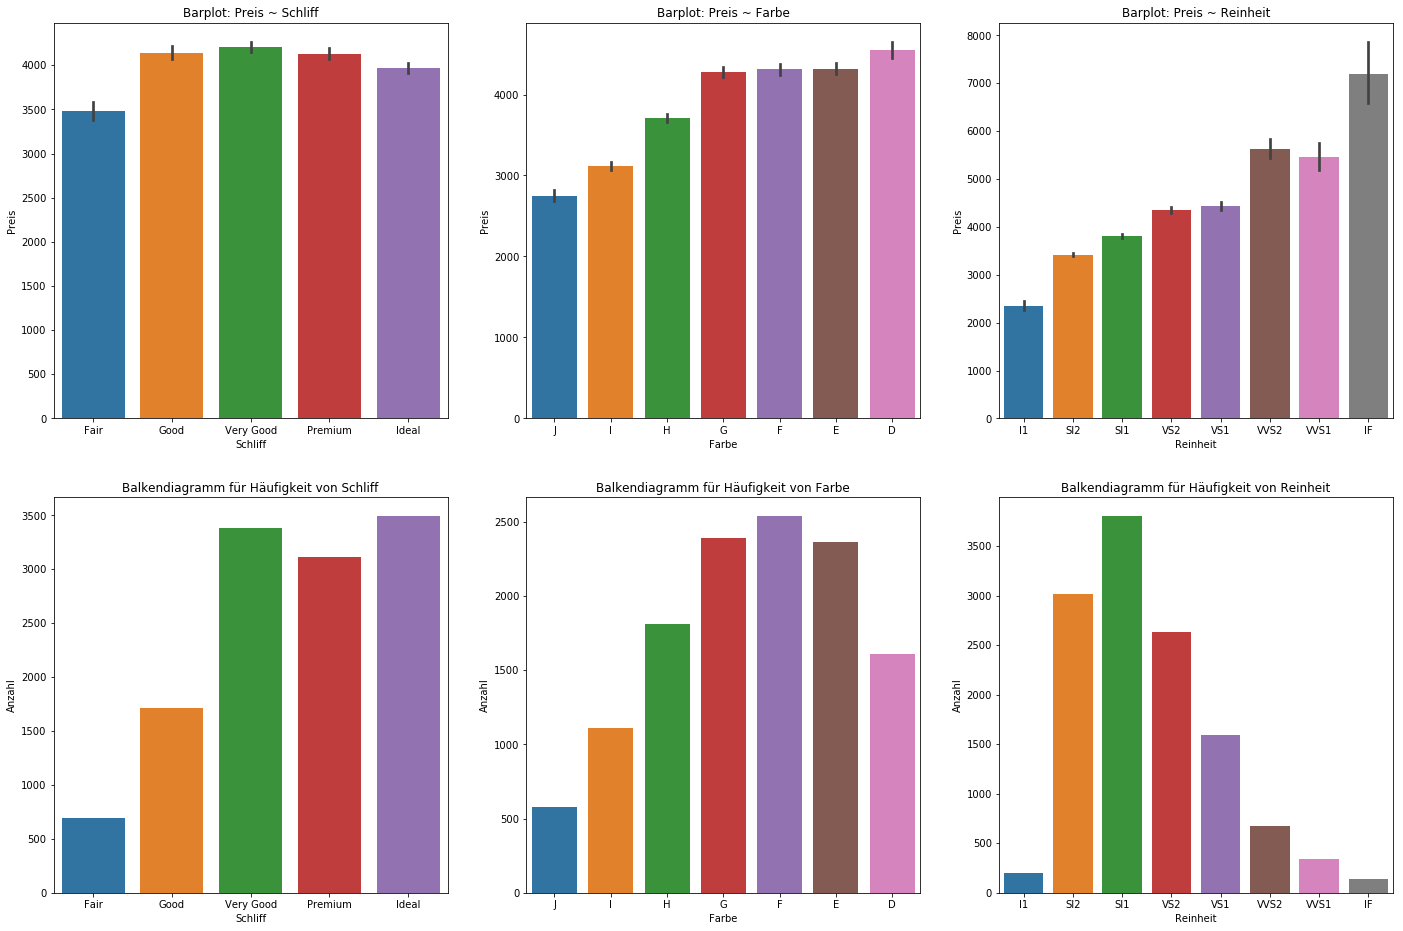

In [8]:
fig, (ax1,ax2) = plt.subplots(2,3, figsize=(24,16)) 

print("Diamanten 3. Quantil")

#Diagramme
plt.subplot(2,3,1)
sns.barplot(x = data_q3['cut'], y = data_q3['price'], order = ["Fair","Good","Very Good","Premium","Ideal"])
plt.xlabel("Schliff")
plt.ylabel("Preis")
plt.title('Barplot: Preis ~ Schliff')

plt.subplot(2,3,2)
sns.barplot(x = data_q3['color'], y = data_q3['price'], order = ["J","I","H","G","F","E","D"])
plt.xlabel("Farbe")
plt.ylabel("Preis")
plt.title('Barplot: Preis ~ Farbe')

plt.subplot(2,3,3)
sns.barplot(x = data_q3['clarity'], y = data_q3['price'], order = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"])
plt.xlabel("Reinheit")
plt.ylabel("Preis")
plt.title('Barplot: Preis ~ Reinheit')

plt.subplot(2,3,4)
sns.countplot(x = data_q3['cut'], order = ["Fair","Good","Very Good","Premium","Ideal"])
plt.xlabel("Schliff")
plt.ylabel("Anzahl")
plt.title('Balkendiagramm für Häufigkeit von Schliff')

plt.subplot(2,3,5)
sns.countplot(x = data_q3['color'], order = ["J","I","H","G","F","E","D"])
plt.xlabel("Farbe")
plt.ylabel("Anzahl")
plt.title('Balkendiagramm für Häufigkeit von Farbe')

plt.subplot(2,3,6)
sns.countplot(x = data_q3['clarity'], order = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"])
plt.xlabel("Reinheit")
plt.ylabel("Anzahl")
plt.title('Balkendiagramm für Häufigkeit von Reinheit')

plt.show()

Diamanten 4. Quantil


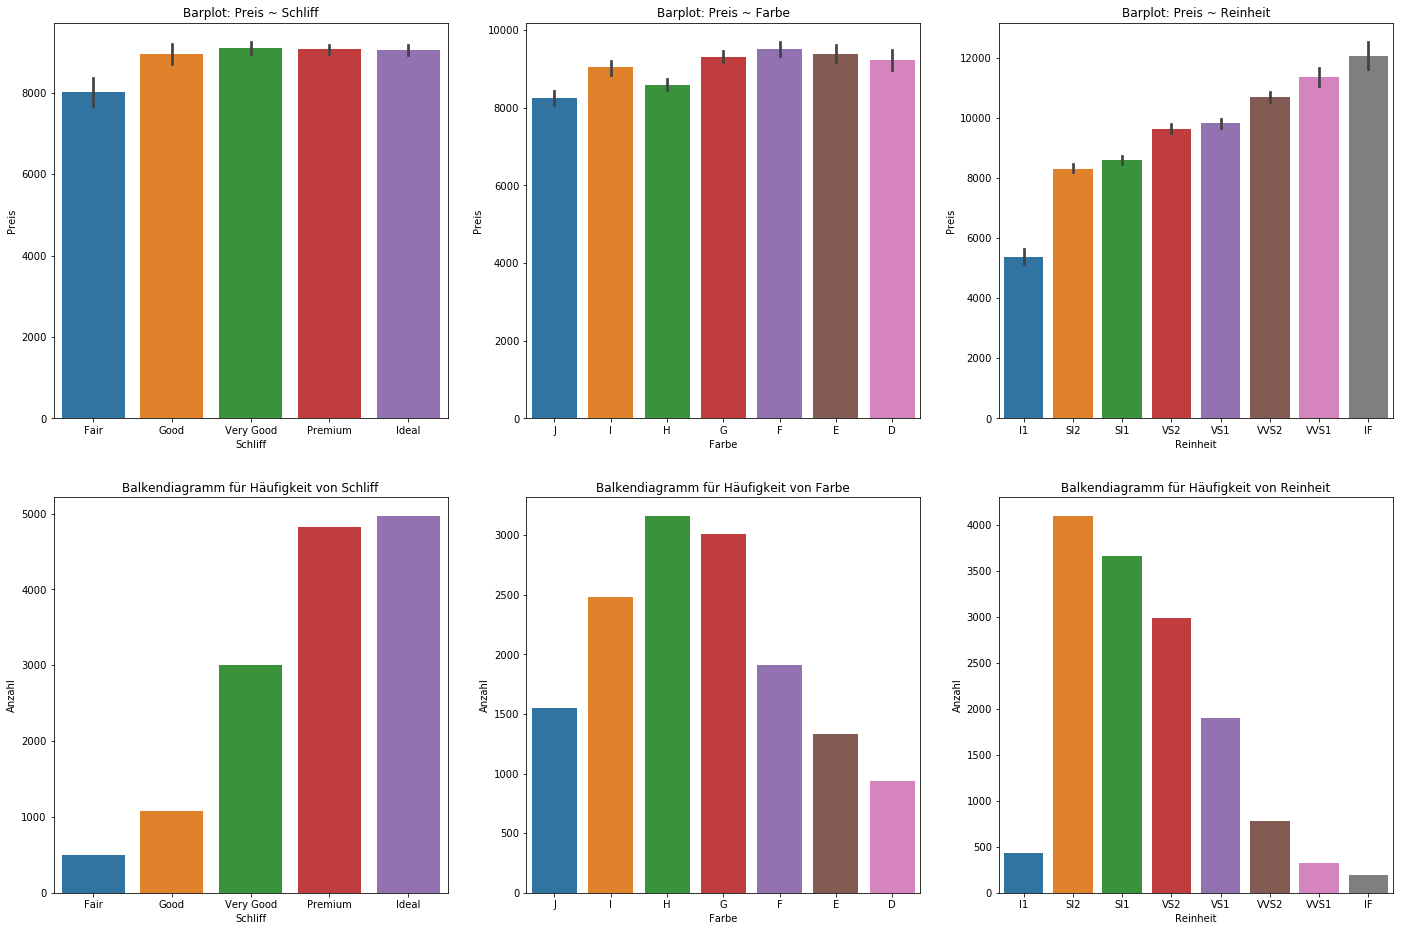

In [9]:
fig, (ax1,ax2) = plt.subplots(2,3, figsize=(24,16)) 

print("Diamanten 4. Quantil")

#Diagramme
plt.subplot(2,3,1)
sns.barplot(x = data_q4['cut'], y = data_q4['price'], order = ["Fair","Good","Very Good","Premium","Ideal"])
plt.xlabel("Schliff")
plt.ylabel("Preis")
plt.title('Barplot: Preis ~ Schliff')

plt.subplot(2,3,2)
sns.barplot(x = data_q4['color'], y = data_q4['price'], order = ["J","I","H","G","F","E","D"])
plt.xlabel("Farbe")
plt.ylabel("Preis")
plt.title('Barplot: Preis ~ Farbe')

plt.subplot(2,3,3)
sns.barplot(x = data_q4['clarity'], y = data_q4['price'], order = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"])
plt.xlabel("Reinheit")
plt.ylabel("Preis")
plt.title('Barplot: Preis ~ Reinheit')

plt.subplot(2,3,4)
sns.countplot(x = data_q4['cut'], order = ["Fair","Good","Very Good","Premium","Ideal"])
plt.xlabel("Schliff")
plt.ylabel("Anzahl")
plt.title('Balkendiagramm für Häufigkeit von Schliff')

plt.subplot(2,3,5)
sns.countplot(x = data_q4['color'], order = ["J","I","H","G","F","E","D"])
plt.xlabel("Farbe")
plt.ylabel("Anzahl")
plt.title('Balkendiagramm für Häufigkeit von Farbe')

plt.subplot(2,3,6)
sns.countplot(x = data_q4['clarity'], order = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"])
plt.xlabel("Reinheit")
plt.ylabel("Anzahl")
plt.title('Balkendiagramm für Häufigkeit von Reinheit')

plt.show()

Zunächst ist auffällig, dass der Zusammenhang von Farbe, Reinheit und Schliff innerhalb der Quantile grundsätzlich wie erwartet ist (bis auf einige Ausnahmen, vermutlich durch Zufall oder Schwankungen entstehen). Das bedeutet, dass der Preis ähnlich schwerer Diamanten wie erwartet positiv durch höherwertige Qualitätsmerkmale beeinflusst wird.

Allerdings kann man auch erkennen, dass leichte Diamanten in den unteren Quantilen häufiger höherwertige Merkmale bei Schliff, Farbe und Reinheit aufweisen. Die höherwertigen Diamanten sind also überwiegend in den unteren Gewichtsklassen, wohingegen Diamanten mit schlechteren Qualitätsmerkmalen in den oberen Gewichtsklassen zu finden sind. Durch das Gewicht werden übrige Qualitätsunterschiede allerdings mehr als kompensiert, wodurch der Durchschnittspreis innerhalb der Merkmale dann verzerrt wird.

Deutlich wird die anhand des Beispiels Reinheit (siehe unten). Es gibt besonders viele Diamanten mit der Reinheit „Internally flawless“ (der hochwertigsten Stufe) in den unteren Gewichtsklassen. Der Durchschnittspreis ist aber aufgrund des Gewichtes bei schwereren Diamanten höher. Bei Diamanten der Reinheit SI2 („small inclusions“, weniger hochwertig) ist es genau anders herum. Es gibt vergleichsweise sehr viele Diamanten in den oberen Gewichtsklassen, die dementsprechend teurer sind. Dadurch werden die Durchschnittswerte stark verzerrt.

Zusammengefasst lässt sich feststellen, dass das Gewicht einen sehr starken Einfluss auf den Preis hat. Der unerwartete, negative Zusammenhang der Merkmale Farbe, Schliff und Reinheit ist auf die ungleiche Verteilung zurückzuführen. Diamanten mit höherwertigen Qualitätsmerkmalen sind überwiegend in niedrigen Gewichtsklassen zu finden, wohingegen die höheren Gewichtsklassen relativ viele ansonsten weniger hochwertige Diamanten fassen. Durch das Gewicht wird dieser Qualitätsunterschied jedoch mehr als ausgeglichen, wodurch bei Betrachtung aller Gewichtsklassen zusammen der Eindruck entsteht, dass höherwertige Qualitätsmerkmale zu niedrigeren Preisen führen.

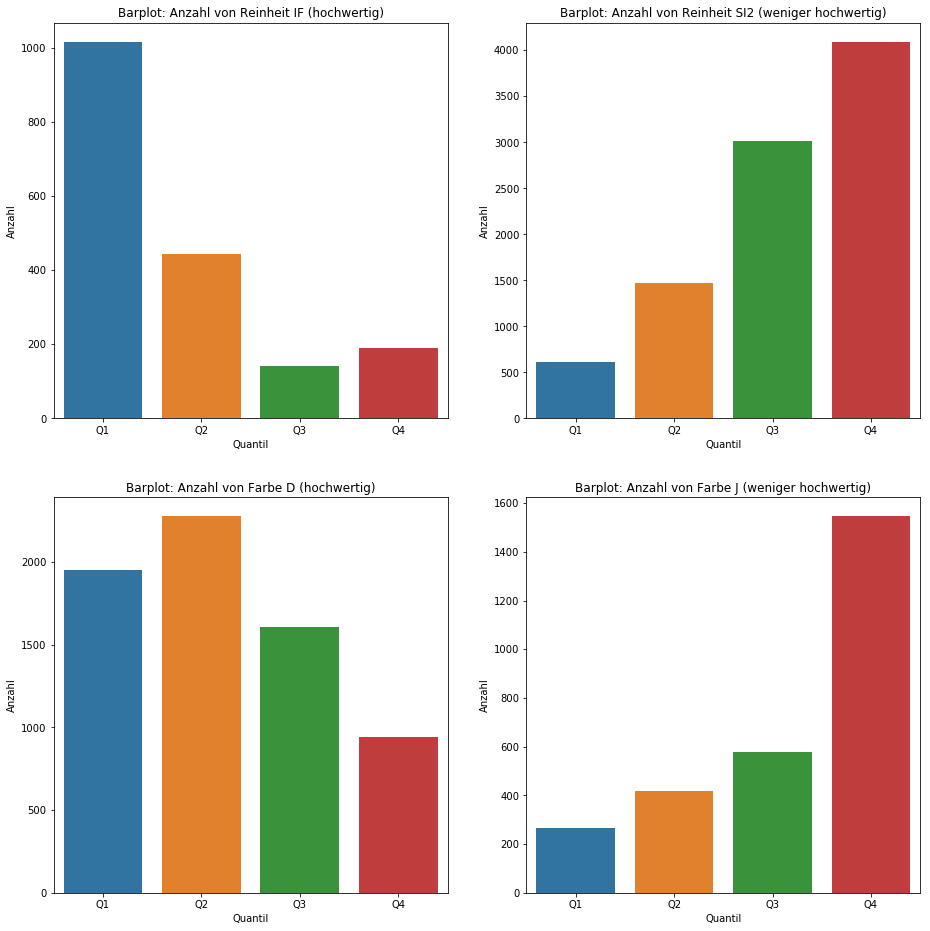

In [10]:
fig, (ax1,ax2) = plt.subplots(2,2, figsize=(24,16)) 

#Diagramme
plt.subplot(2,3,1)
sns.barplot(x = ["Q1",
                 "Q2",
                 "Q3",
                 "Q4"], 
            y = [len(data_q1[data_q1['clarity'] == "IF"]),
                 len(data_q2[data_q2['clarity'] == "IF"]),
                 len(data_q3[data_q3['clarity'] == "IF"]),
                 len(data_q4[data_q4['clarity'] == "IF"])])
plt.xlabel("Quantil")
plt.ylabel("Anzahl")
plt.title('Barplot: Anzahl von Reinheit IF (hochwertig)')

plt.subplot(2,3,2)
sns.barplot(x = ["Q1",
                 "Q2",
                 "Q3",
                 "Q4"], 
            y = [len(data_q1[data_q1['clarity'] == "SI2"]),
                 len(data_q2[data_q2['clarity'] == "SI2"]),
                 len(data_q3[data_q3['clarity'] == "SI2"]),
                 len(data_q4[data_q4['clarity'] == "SI2"])])
plt.xlabel("Quantil")
plt.ylabel("Anzahl")
plt.title('Barplot: Anzahl von Reinheit SI2 (weniger hochwertig)')

plt.subplot(2,3,4)
sns.barplot(x = ["Q1",
                 "Q2",
                 "Q3",
                 "Q4"], 
            y = [len(data_q1[data_q1['color'] == "D"]),
                 len(data_q2[data_q2['color'] == "D"]),
                 len(data_q3[data_q3['color'] == "D"]),
                 len(data_q4[data_q4['color'] == "D"])])
plt.xlabel("Quantil")
plt.ylabel("Anzahl")
plt.title('Barplot: Anzahl von Farbe D (hochwertig)')

plt.subplot(2,3,5)
sns.barplot(x = ["Q1",
                 "Q2",
                 "Q3",
                 "Q4"], 
            y = [len(data_q1[data_q1['color'] == "J"]),
                 len(data_q2[data_q2['color'] == "J"]),
                 len(data_q3[data_q3['color'] == "J"]),
                 len(data_q4[data_q4['color'] == "J"])])
plt.xlabel("Quantil")
plt.ylabel("Anzahl")
plt.title('Barplot: Anzahl von Farbe J (weniger hochwertig)')

plt.show()

### Korrelationsmatrix
Für die weitere Betrachtung müssen die ordinalen Daten der Merkmale Farbe, Schliff und Reinheit in numerische Werte umgewandelt werden. Dafür wird die qualitativ niedrigste Merkmalsausprägung mit dem Wert 1 gemappt und von dann aufsteigend jede weitere, höherwertige Ausprägung mit der nächsten ganzen Zahl gemappt. Dadurch soll die Reihenfolge beziehungsweise die Hierarchie in den Daten erhalten bleiben.

In [10]:
data['cut'] = data['cut'].apply(lambda x: 1 if x=='Fair' 
                                     else(2 if x=='Good' 
                                     else(3 if x=='Very Good' 
                                     else(4 if x=='Premium' else 5))))

data['color'] = data['color'].apply(lambda x: 1 if x=='J' 
                                         else(2 if x=='I'
                                         else(3 if x=='H'
                                         else(4 if x=='G'
                                         else(5 if x=='F'
                                         else(6 if x=='E' else 7))))))

data['clarity'] = data['clarity'].apply(lambda x: 1 if x=='I1' 
                                             else(2 if x=='SI2'
                                             else(3 if x=='SI1'
                                             else(4 if x=='VS2'
                                             else(5 if x=='VS1'
                                             else(6 if x=='VVS2'
                                             else 7 if x=='VVS1' else 8))))))

print(data.head(10))

   carat  cut  color  clarity  depth  table  price     x     y     z
0   0.23    5      6        2   61.5   55.0    326  3.95  3.98  2.43
1   0.21    4      6        3   59.8   61.0    326  3.89  3.84  2.31
2   0.23    2      6        5   56.9   65.0    327  4.05  4.07  2.31
3   0.29    4      2        4   62.4   58.0    334  4.20  4.23  2.63
4   0.31    2      1        2   63.3   58.0    335  4.34  4.35  2.75
5   0.24    3      1        6   62.8   57.0    336  3.94  3.96  2.48
6   0.24    3      2        7   62.3   57.0    336  3.95  3.98  2.47
7   0.26    3      3        3   61.9   55.0    337  4.07  4.11  2.53
8   0.22    1      6        4   65.1   61.0    337  3.87  3.78  2.49
9   0.23    3      3        5   59.4   61.0    338  4.00  4.05  2.39


Die Beziehungen der Daten untereinander werden mittels einer Korrelationsmatrix analysiert. Die Korrelationsmatrix wird vom DataFrame[[21]](#dataframe) berechnet und mittels Seaborn[[22]](#heatmap) dargestellt. Positive Korrelationen werden grün dargestellt, negative Korrelationen werden rot dargestellt.

In der Korrelationsmatrix lässt sich der leicht negative Zusammenhang der Merkmale Schliff, Farbe und Reinheit mit dem Preis erkennen. Dieser unerwartete Zusammenhang muss weiter analysiert werden.

Bei den Merkmalen Tisch und Tiefe lässt sich kein starker Zusammenhang mit anderen Merkmalen erkennen.

Zu erkennen ist allerdings auch, dass die Merkmale x (Länge), y (Breite) und z (Höhe) sehr stark miteinander positiv korrelieren. Aufgrund dieses sehr starken linearen Zusammenhangs werden die Merkmale in einem neuen Merkmal Volumen zusammengefasst, welches durch x * y * z berechnet wird. (Das Merkmal wird im weiteren Verlauf der Einfachheit halber als Volumen bezeichnet, entspricht aber natürlich nicht dem mathematisch korrekten Volumen)

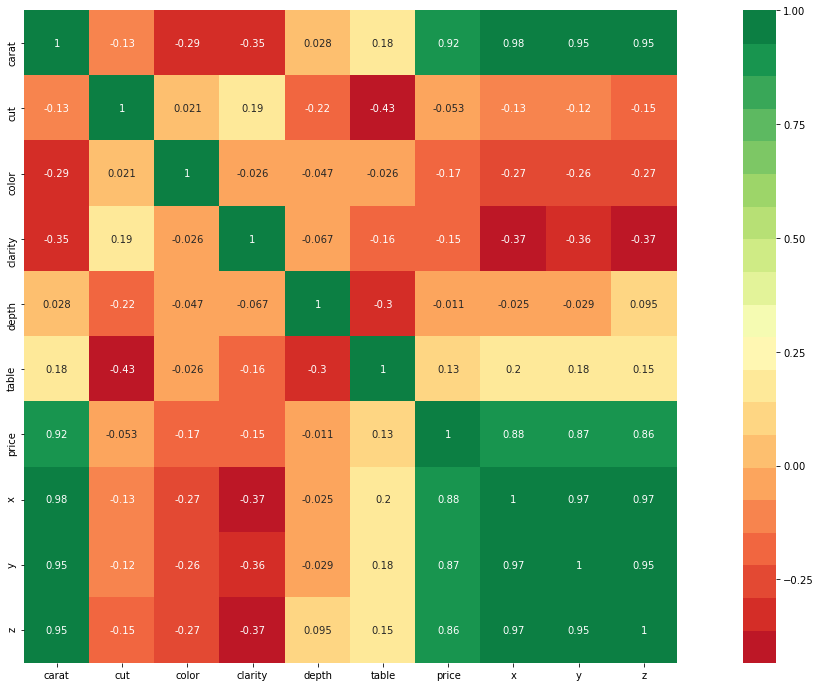

In [4]:
plt.figure(figsize = (24,12))

correlation = data.corr()
sns.heatmap(correlation, vmax=1, annot=True, square=True, cmap = sns.color_palette("RdYlGn", 20))

### Feature: volume

Das berechnete Volumen des Diamanten in Quadratmillimentern
<br>Skala: mertisch/verhältnisskaliert

Beobachtung
* Rechtsschiefe Verteilung
* Positiver Zusammenhang zum Preis erkennbar

Fazit:
* Preis und Volumen korrelieren


   carat  cut  color  clarity  depth  table  price     volume
0   0.23    5      6        2   61.5   55.0    326  38.202030
1   0.21    4      6        3   59.8   61.0    326  34.505856
2   0.23    2      6        5   56.9   65.0    327  38.076885
3   0.29    4      2        4   62.4   58.0    334  46.724580
4   0.31    2      1        2   63.3   58.0    335  51.917250
5   0.24    3      1        6   62.8   57.0    336  38.693952
6   0.24    3      2        7   62.3   57.0    336  38.830870
7   0.26    3      3        3   61.9   55.0    337  42.321081
8   0.22    1      6        4   65.1   61.0    337  36.425214
9   0.23    3      3        5   59.4   61.0    338  38.718000


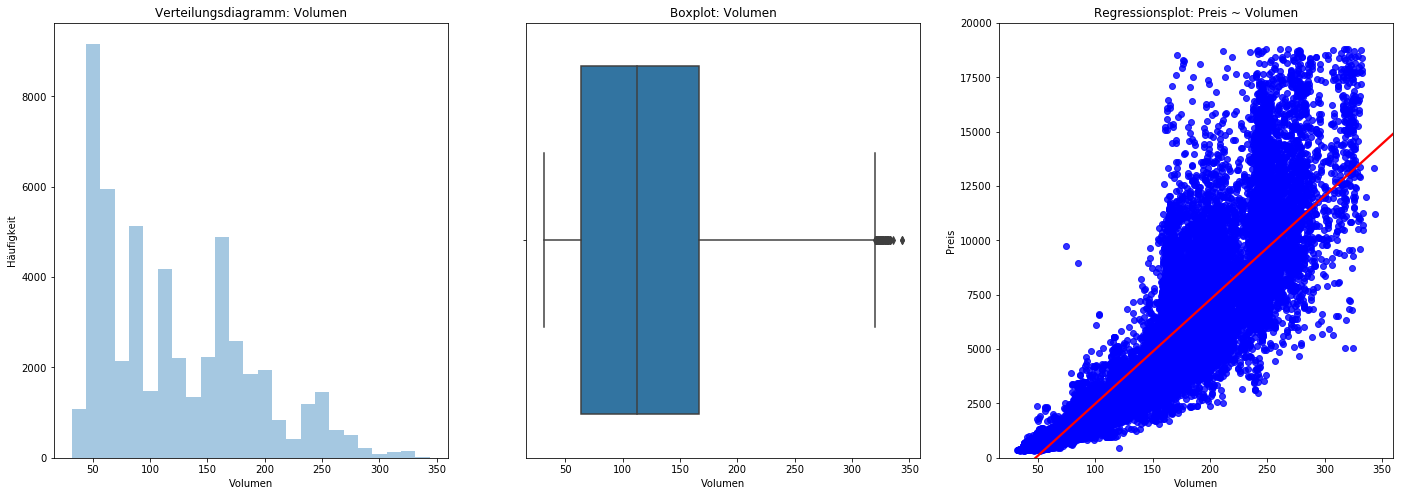

In [11]:
data['volume'] = data['x']*data['y']*data['z']
data.drop(['x','y','z'], axis=1, inplace=True)
print(data.head(10))

fig, (ax1,ax2) = plt.subplots(2,2, figsize=(24,8)) 

#Distplot
plt.subplot(1,3,1)
sns.distplot(data['volume'], kde = False, bins = 25)
plt.xlabel('Volumen')
plt.ylabel('Häufigkeit')
plt.title('Verteilungsdiagramm: Volumen')

#Boxplot
plt.subplot(1,3,2)
sns.boxplot(data['volume'])
plt.xlabel('Volumen')
plt.title('Boxplot: Volumen')

#Regplot
plt.subplot(1,3,3)
sns.regplot(x = 'volume', y = 'price', data = data, scatter_kws = {'color': 'blue'}, line_kws = {'color': 'red'})
plt.ylim(0,20000)
plt.xlabel('Volumen')
plt.ylabel('Preis')
plt.title('Regressionsplot: Preis ~ Volumen')

plt.show()

### Multivariate Analyse



Bei der multivariaten Analyse wird der Zusammenhang von mehreren Merkmalen in Bezug auf den Preis analysiert.

Die Analyse erfolgt mittels Pairplots[[23]](#pairplot), wobei immer zwei Merkmale in einem Diagramm dargestellt werden. Die Punkte werden je nach Preis dann unterschiedlich eingefärbt. Die Färbung erfolgt von rot (besonders günstig) nach grün (besonders teuer).

Zur Vereinfachung der Darstellung und Performanz werden die Preise auf ganze Tausender gerundet.

In [12]:
data_rounded = data.copy()

#Funktion zum Runden der Daten
def custom_round(x, base=1000):
    return int(base * round(float(x)/base))

#Daten auf 1.000er runden
data_rounded['price'] = data_rounded['price'].apply(lambda x: custom_round(x, base=1000))

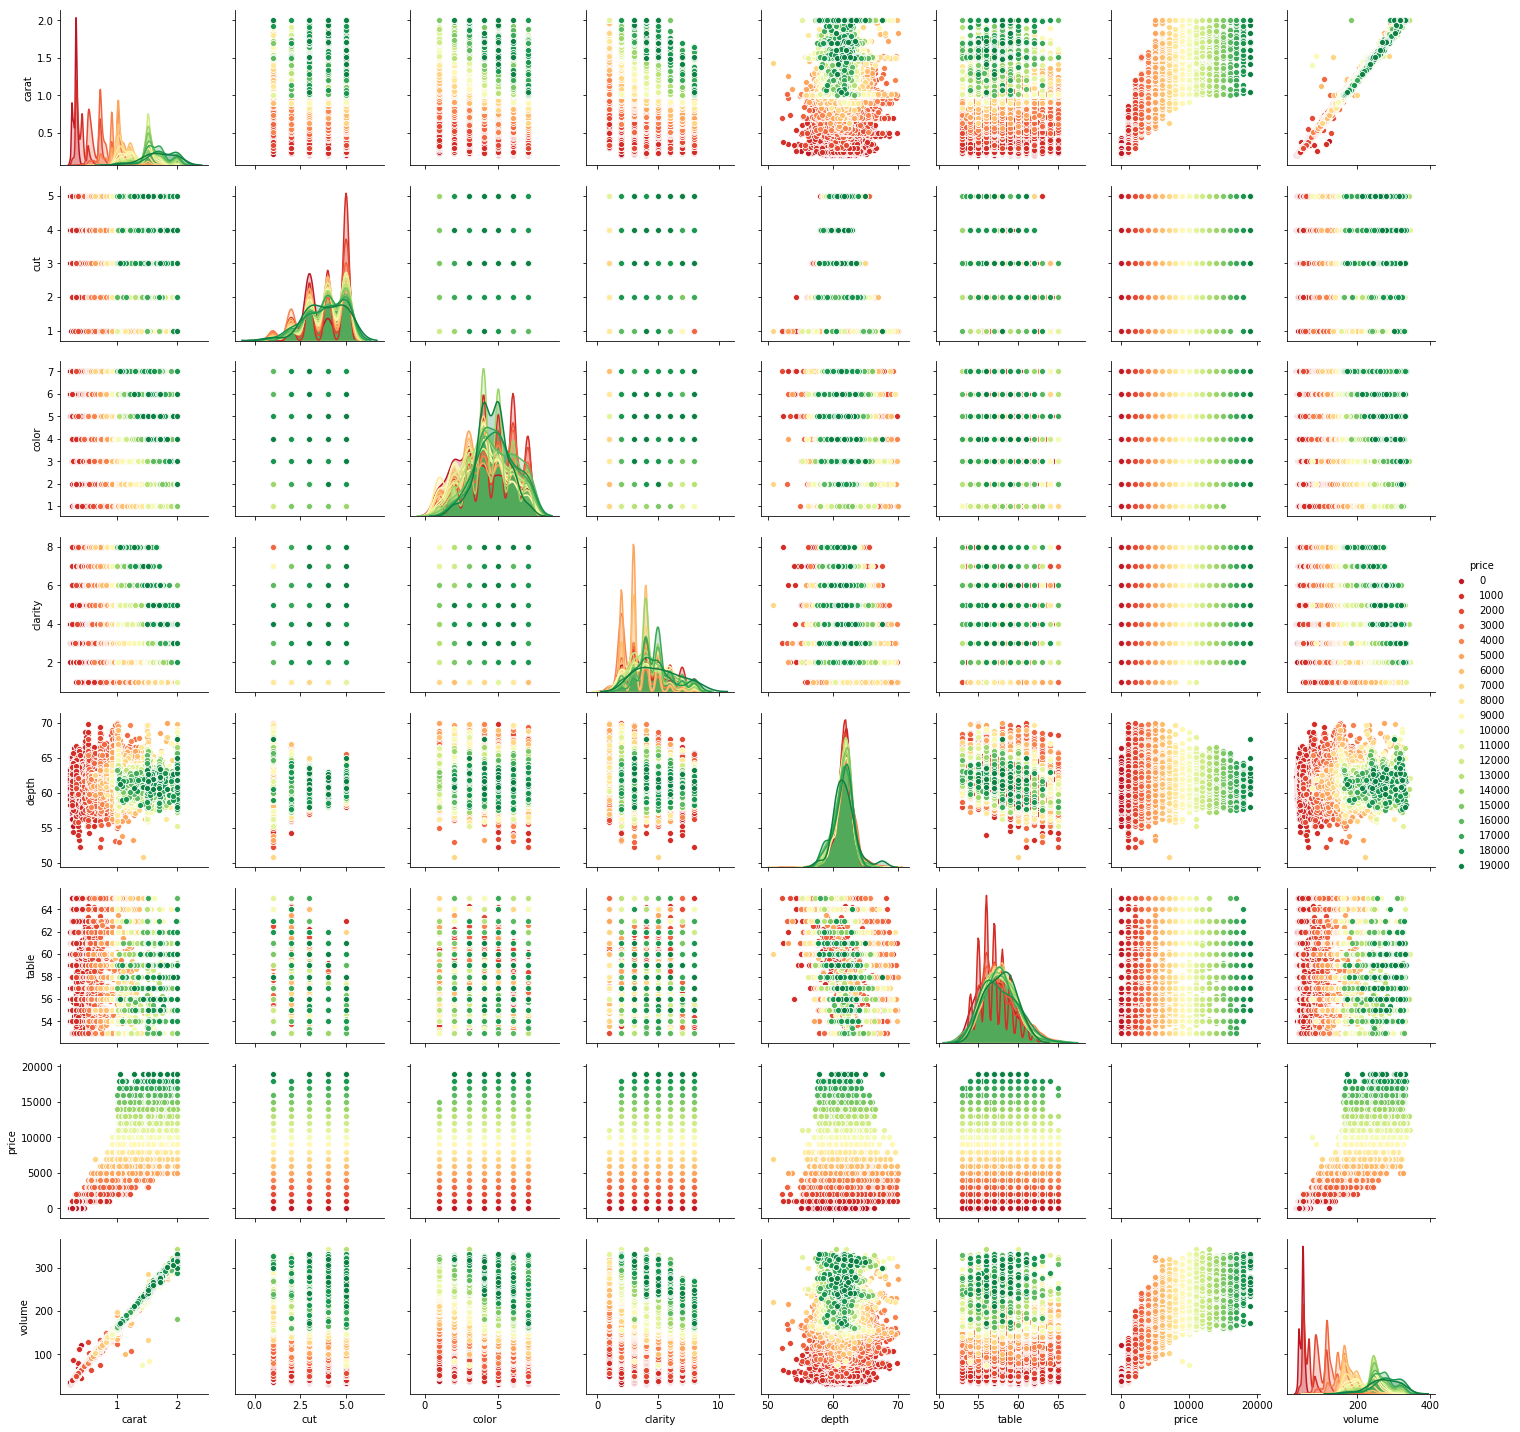

In [13]:
sns.pairplot(data_rounded, hue = 'price', palette = sns.color_palette("RdYlGn", 20))
plt.show()

Marker für Präsentation (bitte ignorieren)<a class="anchor" id="markerpairplots"></a>

Zunächst ist ein sehr starker (fast perfekter) linearer Zusammenhang zwischen Karat und Volumen erkennbar. Die Visualisierung wurde mittels Scatterplot[[24]](#scatterplot) vergrößert:

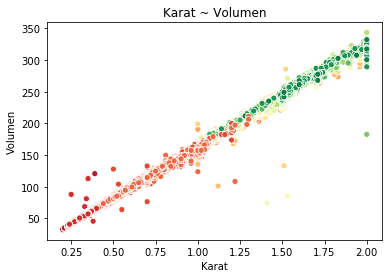

In [16]:
sns.scatterplot(data = data_rounded, x = 'carat', y = 'volume', hue = 'price', palette = sns.color_palette("RdYlGn", 20), legend = False)
plt.xlabel('Karat')
plt.ylabel('Volumen')
plt.title('Karat ~ Volumen')
plt.show()

Das untere Diagramm zeigt den Zusammenhand der Farbe (8 ist qualitativ hochwertigste Stufe) und Karat mit dem Preis. Innerhalb der jeweiligen Gruppen nach Reinheit bestimmt Karat ziemlich eindeutig den Preis. Gleichzeitig sieht man aber auch, dass bei gleichem Karat die Reinheit eine Rolle spielt. Diamanten mit einem Karat von 1 und einer minderwertigen Reinheit sind im unteren Preissegment anzuordnen, wobei gleichschwere Diamanten mit einer hochwertigeren Reinheit wesentlich teurer sind.
Derartige Zusammenhänge lassen sich auch für die Merkmale Farbe und Schliff feststellen.

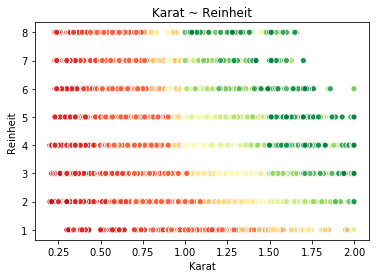

In [15]:
sns.scatterplot(data = data_rounded, x = 'carat', y = 'clarity', hue = 'price', palette = sns.color_palette("RdYlGn", 20), legend = False)
plt.xlabel('Karat')
plt.ylabel('Reinheit')
plt.title('Karat ~ Reinheit')
plt.show()

Allgemein sind verschiedene, teils lineare Zusammenhänge in den Daten erkennbar. Die Merkmale Tisch und Tiefe scheinen allerdings den Preis nur bedingt zu beeinflussen. 

# **Data Preparation**<a class="anchor" id="datapreparation"></a>

Bei den Merkmalen x, y und z müssen einige falsche Datensätze sowie die mit der IQR-Methode berechneten Ausreißer entfernt werden. 
Um nicht zu viele Datensätze zu entfernen, werden die Datensätze folgerdermaßen bereinigt:
Bei dem Merkmal Karat werden Ausreißer mit einem Wert von über 2,0 entfernt. 
Bei dem Merkmal Tiefe werden Ausreißer mit einem Wert von unter 50 und über 70 entfernt. 
Bei dem Merkmal Tisch werden Ausreißer mit einem Wert von unter 53 und über 65 entfernt.
Die ordinalen Merkmale Farbe, Schliff und Reinheit werden wie bereits erklärt in numerische Werte umgewandelt.
Die Merkmale x, y und z werden im neuen Merkmal Volumen zusammengefasst und entfernt.
Zusätzlich werden die Merkmale mittels StandardScaler[[25]](#standardscaler) standardisiert.

In [60]:
#Daten neu einlesen
data = pd.read_csv('diamonds.csv') #https://www.kaggle.com/shivam2503/diamonds
data = data.drop('Unnamed: 0', 1) #Zeilennummer in CSV-Datei, kann daher entfernt werden

print("Vor Datenvorbereitung:\n")
print(data.head(10))

#Falsche Daten und Ausreißer aus x, y und z entfernen
data = data[data['x'] > 1.965]
data = data[data['x'] < 9.285]
data = data[data['y'] > 2.01]
data = data[data['y'] < 9.27]
data = data[data['z'] > 1.215]
data = data[data['z'] < 5.735]

#Ausreißer aus Karat entfernen (größer als 2,0)
data = data[data['carat'] <= 2.0]

#Ausreißer aus Tiefe entfernen (größer als 70 und kleiner als 50)
data = data[data['depth'] <= 70]
data = data[data['depth'] >= 50]

#Ausreißer aus Tisch entfernen (größer als 65 und kleiner als 53)
data = data[data['table'] <= 65]
data = data[data['table'] >= 53]

#Volumen erzeugen und x, y und z entfernen
data['volume'] = data['x']*data['y']*data['z']
data.drop(['x','y','z'], axis=1, inplace=True)

#Ordinale Merkmale kodieren
data['cut'] = data['cut'].apply(lambda x: 1 if x=='Fair' 
                                     else(2 if x=='Good' 
                                     else(3 if x=='Very Good' 
                                     else(4 if x=='Premium' else 5))))

data['color'] = data['color'].apply(lambda x: 1 if x=='J' 
                                         else(2 if x=='I'
                                         else(3 if x=='H'
                                         else(4 if x=='G'
                                         else(5 if x=='F'
                                         else(6 if x=='E' else 7))))))

data['clarity'] = data['clarity'].apply(lambda x: 1 if x=='I1' 
                                             else(2 if x=='SI2'
                                             else(3 if x=='SI1'
                                             else(4 if x=='VS2'
                                             else(5 if x=='VS1'
                                             else(6 if x=='VVS2'
                                             else 7 if x=='VVS1' else 8))))))

print("\nNach Bereinigung:\n")
print(data.head(10))

#Merkmale und Zielvariable trennen
y = data['price']
X = data.drop(['price'], axis = 1)

#Standardisierung
scaler = StandardScaler()
X = scaler.fit_transform(X)

print("\nNach Skalierung:\n")
print(X[:10])

Vor Datenvorbereitung:

   carat        cut color clarity  depth  table  price     x     y     z
0   0.23      Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21    Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23       Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
5   0.24  Very Good     J    VVS2   62.8   57.0    336  3.94  3.96  2.48
6   0.24  Very Good     I    VVS1   62.3   57.0    336  3.95  3.98  2.47
7   0.26  Very Good     H     SI1   61.9   55.0    337  4.07  4.11  2.53
8   0.22       Fair     E     VS2   65.1   61.0    337  3.87  3.78  2.49
9   0.23  Very Good     H     VS1   59.4   61.0    338  4.00  4.05  2.39

Nach Bereinigung:

   carat  cut  color  clarity  depth  table  price     volume
0   0.23    5      6        2   61.5   55.0    326  38.202030
1   0.21    4      6        3

# **Modeling und Evaluation**<a class="anchor" id="modelingundevaluation"></a>

Die Erstellung des Modells erfolgt in drei Schritten. Zunächst wird ein möglichst gut geeignetes Modell für den Anwendungsfall ausgewählt. Dieses Modell wird dann mittels Hyperparameter optimiert. Anschließend wird das fertige Modell (sofern möglich) visualisiert.

## Auswahl eines geeigneten Algorithmus

Die Auswahl eines möglichst geeigneten Modells erfolgt durch Ausprobieren verschiedener Algorithmen. Die Güte der Modelle wird anhand folgender Metriken bewertet:
* Bestimmtheitsmaß r2 [[26]](#bestimmtheitsmaß)
* Durchschnittlicher Absoluter Fehler [[27]](#absoluterfehler)
* Durchschnittlicher Quadrierter Fehler [[28]](#quadrierterfehler)
* Durchschnittliche Abweichung
<br>Die durchschnittliche Abweichung berechnet sich, in dem die prozentuale Abweichung vom echten zum vorhergesagten Wert für jede Vorhersage berechnet wird. Damit sich negative und positive Werte nicht gegenseitig ausgleichen, werden negative Werte in positive Werte umgewandelt. Aus diesen Werten wird dann der Durchschnitt gebildet. Dieses Qualitätsmaß soll bei der Beurteilung des Modells mit Blick auf die Zielsetzung unterstützen. Die Berechnung wurde selbst implementiert und wird mittels make_scorer [[29]](#makescorer) von scikit-learn eingebunden.

Dem Algorithmus werden bei der Erstellung des Modells nicht alle Daten zur Verfügung gestellt. Die Daten, mit denen das Modell erstellt wird, werden Trainingsdaten genannt. Ein Teil der Daten wird dem Modell allerdings vorenthalten. Diese Daten werden dann verwendet, um das Modell (mit dem Modell unbekannten Daten) zu testen und zu bewerten. Das Vorenthalten von Daten mindert jedoch die Qualität des Modells. Um diesen Zustand zu kompensieren, wird die sogenannte Kreuzvalidierung angewandt. Dabei werden die Daten in verschiedene Teildatenmengen aufgeteilt, im konkreten Fall werden fünf Teilmengen erstellt (fünffache Kreuzvalidierung). Das Modell wird dann fünf Mal erstellt, wobei immer vier Teildatenmengen als Trainingsdaten und eine Teildatenmenge als Testdaten verwendet wird. Die einzelnen Qualitätsmaße werden jedes Mal berechnet. Am Ende werden dann die Durchschnittswerte der berechneten Qualitätsmaße als Endergebnis zurückgegeben[[30]](#kreuzvalidierung).

Dafür wird die von scikit-learn bereitgestellte Implementierung cross_validate [[31]](#cross_validate) genutzt. Außerdem wir hier die scikit-learn-eigene Implementierung RepeatedKFold[[32]](#repeatedkfold) benutzt. Dabei wird die Kreuzvalidierung für jedes Modell drei mal wiederholt. Insgesamt wird jedes Modell also fünfzehn Mal erstellt und bewertet, um zufällige günstige oder ungünstige Verteilungen auszuschließen und die Qualitätsmaße möglichst realitätsnah zu berechnen.

In [3]:
def mean_absolute_deviation(y_true_list, y_pred_list):
    
    sum_deviation = 0
    
    for y_true, y_pred in zip(y_true_list, y_pred_list):
        
        deviation = (((y_pred / y_true) - 1) * 100)
        
        if deviation >= 0:
            
            sum_deviation += deviation
            
        if deviation < 0:
            
            sum_deviation += (deviation * -1)
        
    return (sum_deviation / len(y_true_list))

kfold = RepeatedKFold(n_splits = 5, n_repeats = 3)

scorer = { 'r2' : 'r2',
           'neg_mean_absolute_error' : 'neg_mean_absolute_error',
           'neg_mean_squared_error' : 'neg_mean_squared_error',
           'mean_absolute_deviation' : make_scorer(mean_absolute_deviation, greater_is_better = False)}

Es werden folgende Algorithmen getestet[[33]](#algorithmen):
<br>Lineare Regression
<br>Ridge-Regression
<br>Lasso-Regression
<br>ElasticNet-Regression
<br>RandomForestRegressor
<br>AdaBoostRegressor
<br>SGDRegressor
<br>KNeighborsRegressor
<br>MLPRegressor
<br>Quadratische Regression

In [6]:
results = pd.DataFrame(columns=("Algorithmus", "Bestimmtheitsmaß (R²)", "Durchschn. Abs. Fehler", "Durchschn. Quad. Fehler"))

models = {LinearRegression(), Ridge(), Lasso(), ElasticNet(), RandomForestRegressor(), AdaBoostRegressor(), SGDRegressor(), KNeighborsRegressor(), MLPRegressor()}

for model in models:

    cv_results = cross_validate(model, X, y, cv = kfold, scoring = scorer, return_train_score = True, n_jobs = -1)
    
    results = results.append({"Algorithmus" : model.__class__.__name__, 
                          "Bestimmtheitsmaß (R²)" : np.mean(cv_results["test_r2"]), 
                          "Durchschn. Abs. Fehler" : np.mean(cv_results["test_neg_mean_absolute_error"]*-1), 
                          "Durchschn. Quad. Fehler" : np.mean(cv_results["test_neg_mean_squared_error"]*-1), 
                          "Durchschn. Abweichung" : np.mean(cv_results['test_mean_absolute_deviation']*-1)},
                         ignore_index = True)
    
del models

#Polynomische Regression (Quadratisch)
polynomial_features = PolynomialFeatures(degree=2)
X_poly = polynomial_features.fit_transform(X)

cv_results = cross_validate(LinearRegression(), X_poly, y, cv = kfold, scoring = scorer, return_train_score = True, n_jobs = -1)
    
results = results.append({"Algorithmus" : "Quadtratische Regression", 
                          "Bestimmtheitsmaß (R²)" : np.mean(cv_results["test_r2"]), 
                          "Durchschn. Abs. Fehler" : np.mean(cv_results["test_neg_mean_absolute_error"]*-1), 
                          "Durchschn. Quad. Fehler" : np.mean(cv_results["test_neg_mean_squared_error"]*-1), 
                          "Durchschn. Abweichung" : np.mean(cv_results['test_mean_absolute_deviation']*-1)},
                         ignore_index = True)

print(results)

                Algorithmus  Bestimmtheitsmaß (R²)  Durchschn. Abs. Fehler  Durchschn. Quad. Fehler  Durchschn. Abweichung
0              SGDRegressor          -5.431578e+18            6.336526e+12             6.273127e+25           3.432677e+11
1         AdaBoostRegressor           9.004647e-01            8.599110e+02             1.160840e+06           4.676213e+01
2                ElasticNet           8.909325e-01            7.770958e+02             1.272508e+06           4.323808e+01
3     RandomForestRegressor           9.813584e-01            2.505905e+02             2.174321e+05           8.451065e+00
4          LinearRegression           8.935264e-01            7.942470e+02             1.242139e+06           4.890222e+01
5                     Ridge           8.935372e-01            7.942022e+02             1.242210e+06           4.888872e+01
6                     Lasso           8.934418e-01            7.940681e+02             1.243018e+06           4.876612e+01
7       KNeighbo

Der RandomForestRegressor schneidet bei allen Qualitätsmaßen bei weitem am besten ab. Ausnahme ist hier nur das Bestimmtheitsmaß, was allerdings nur leicht unter den Ergebnissen einiger anderer Algorithmen liegt. Vor allem der niedrige durchschnittliche quadrierte Fehler und die niedrige durchschnittliche Abweichung sprechen für den RandomForestRegressor. Daher wird dieser Algorithmus für die weitere Bearbeitung verwendet.

Normalerweise spielt eine Standardisierung für den RandomForestRegressor[[34]](#randomforest) keine Rolle. Von daher wird geprüft, ob die Standardisierung die Ergebnisse beeinflusst. Dafür wird je ein Modell mit standardisierten und nicht-standardisierten Daten erstellt und verglichen:

In [61]:
#Merkmale und Zielvariable trennen (ohne Skalierung)
y = data['price']
X = data.drop(['price'], axis = 1)

In [8]:
results = pd.DataFrame(columns=("Algorithmus", "Bestimmtheitsmaß (R²)", "Durchschn. Abs. Fehler", "Durchschn. Quad. Fehler"))

model = RandomForestRegressor()

cv_results = cross_validate(model, X, y, cv = kfold, scoring = scorer, return_train_score = True, n_jobs = -1)
    
results = results.append({"Algorithmus" : model.__class__.__name__, 
                      "Bestimmtheitsmaß (R²)" : np.mean(cv_results["test_r2"]), 
                      "Durchschn. Abs. Fehler" : np.mean(cv_results["test_neg_mean_absolute_error"]*-1), 
                      "Durchschn. Quad. Fehler" : np.mean(cv_results["test_neg_mean_squared_error"]*-1), 
                      "Durchschn. Abweichung" : np.mean(cv_results['test_mean_absolute_deviation']*-1)},
                     ignore_index = True)

print(results)

             Algorithmus  Bestimmtheitsmaß (R²)  Durchschn. Abs. Fehler  Durchschn. Quad. Fehler  Durchschn. Abweichung
0  RandomForestRegressor               0.981445              250.649046            216444.715789               8.466576


Es zeigt sich, dass eine Standardisierung keine Vorteile bringt. Zur besseren Interpretierbarkeit des Modells wird daher mit den nicht-standardisierten Daten fortgefahren.

## Hyperparameter-Optimierung

Beim RandomForestRegressor werden mehrere Entscheidungsbäume in einem Modell vereint. Bei einem Entscheidungsbaum versucht das Modell, die Daten an jedem Knoten anhand eines Merkmals in möglichst ähnliche in Teilmengen aufzuteilen. Diese Teilmengen werden dann am nächsten Knoten erneut aufgeteilt und so weiter. Wenn die Daten innerhalb eines Knotens sehr ähnlich sind und eine weitere Teilung keinen zusätzlichen Mehrwert bringt, wird aus dem Knoten ein Blatt. Das Blatt bekommt dann einen bestimmten Wert zugewiesen.

Wenn der Entscheidungsbaum dann eine Instanz übergeben bekommt, durchläuft die Instanz den Entscheidungsbaum und endet an einem Blatt. Der dem Blatt zugewiesene Wert wird dann als Ergebnis zurückgegeben.

Bei einem RandomForest werden mehrere Entscheidungsbäume erstellt, wobei jede Instanz von jedem Baum bewertet wird. Die Werte werden dann zu einem Ergebnis kombiniert, das das Modell zurückgibt[[35]](#randomforesterklärung).

Der RandomForest bietet verschiedene Einstellungsmöglichkeiten, mit der man das Modell verändern und optimieren kann. Die beiden wichtigsten sind:
* criterion: Das Entscheidungskriterium, mit dem die Daten an Knoten geteilt werden
* n_estimators: Die Anzahl an Entscheidungsbäumen

Diese beiden Parameter werden durch die sogenannte GridSearch[[36]](#gridsearch) optimiert. Dabei werden nacheinander verschiedene Parameter ausprobiert. Der Parameter, bei dem das Modell die besten Ergebnisse liefert, wird dann beibehalten.

In [9]:
params = {'criterion': ['mse', 'mae']}

model = RandomForestRegressor(random_state = 0)

grid_search = GridSearchCV(model, params, cv = kfold, scoring = "r2", n_jobs = -1, verbose = 3)

grid_search.fit(X, y)

print(grid_search.best_params_)
print(grid_search.best_score_)
print("\n")

Fitting 15 folds for each of 2 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:  7.8min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 10.1min finished


{'criterion': 'mse'}
0.9815350596311757




Bei der Bestimmung der Anzahl der Entscheidungsbäume im Random Forest handelt es sich um einen Trade-Off. Generell gilt, dass jeder zusätzliche Baum die Güte (mit abnehmenden Grenznutzen) verbessert. Theoretisch kann der Random Forest aus endlos vielen Bäumen bestehen. Dies ist allerdings aufgrund der verfügbaren Hardware-Ressourcen nicht möglich. Es muss also ein Punkt gefunden werden, an dem weitere Bäume das Modell nicht mehr signifikant verbessern, um so einen optimalen Mittelweg zwischen der Güte des Modells und den verfügbaren Ressourcen zu gehen.

Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 22.8min finished


{'n_estimators': 600}
0.9830969295954861




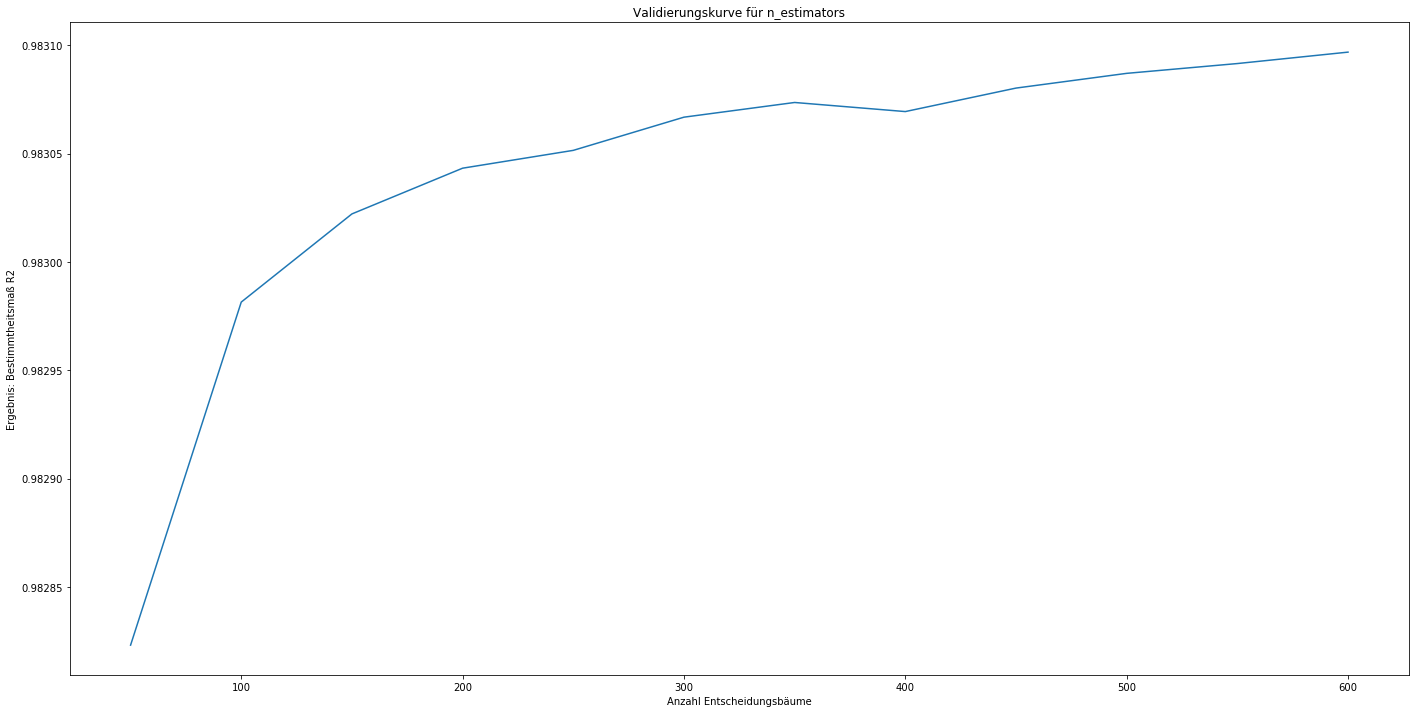

In [10]:
params = {'n_estimators': [50,100,150,200,250,300,350,400,450,500,550,600]}

model = RandomForestRegressor(criterion = 'mse', random_state = 0)

grid_search = GridSearchCV(model, params, cv = kfold, scoring = "r2", n_jobs = -1, verbose = 3)

grid_search.fit(X, y)

print(grid_search.best_params_)
print(grid_search.best_score_)
print("\n")

plt.figure(figsize = (24,12))
plt.plot(params['n_estimators'], grid_search.cv_results_['mean_test_score'])
plt.xlabel("Anzahl Entscheidungsbäume")
plt.ylabel("Ergebnis: Bestimmtheitsmaß R2")
plt.title("Validierungskurve für n_estimators")
plt.show()

In [29]:
print("n_estimators\t r2\t\t\t Durch. Abs. Fehler \t Duch. Quad. Fehler \t Durch. Abs. Abweichung")

for i in range(0,len(params['n_estimators'])):
    
    print(params['n_estimators'][i], "\t\t", cv_results['test_r2'][i], "\t", (cv_results['test_neg_mean_absolute_error'][i])*-1, "\t", (cv_results['test_neg_mean_squared_error'][i])*-1, "\t", (cv_results['test_mean_absolute_deviation'][i])*-1)

n_estimators	 r2			 Durch. Abs. Fehler 	 Duch. Quad. Fehler 	 Durch. Abs. Abweichung
50 		 0.9805872549672703 	 253.69047065413926 	 227180.19319731378 	 8.458809854662663
100 		 0.9803613601754738 	 252.4811687799516 	 228077.6270400752 	 8.480474227968084
150 		 0.982396419748296 	 253.4253730442341 	 214724.14516576086 	 8.515823041591533
200 		 0.9826096339916432 	 242.75914665676328 	 194292.86208504823 	 8.46422258447171
250 		 0.9819453346623852 	 249.52579749103944 	 210121.13164555817 	 8.52440409513244
300 		 0.9804803286755083 	 250.74890426520233 	 223463.8508146406 	 8.533188144473728
350 		 0.9811873240626459 	 252.27345239245014 	 221056.819817027 	 8.481922966671425
400 		 0.9808553154272515 	 255.69018863195268 	 228350.39517194364 	 8.430655344999824
450 		 0.9827115155766065 	 244.3994673326159 	 200029.5480508532 	 8.4912817247506
500 		 0.981682263172746 	 249.9263173269436 	 213122.66233460148 	 8.315348709103464
550 		 0.9806177314879313 	 246.89221795656 	 22301

Wie in der Validierungskurve und der Auflistung erkennbar, sind 200 Entscheidungsbäume ein guter Mittelweg zwischen Güte und Leistungsintesivität des Modells. Der Parameter n_estimators wird also auf 200 gesetzt.

Außerdem soll das Modell auf mögliche Über- oder Unteranpassungen untersucht werden.
Dafür wird das Modell mit Trainingsdaten erstellt. Danach wird das Modell sowohl mit unbekannten Daten (Testdaten) als auch mit den bekannten Trainingsdaten getestet. Die Testergebnisse werden dann verglichen.

Bei einer Überanpassung generalisiert das Modell die Daten nicht ausreichend, stattdessen werden die Daten einfach „auswendig gelernt“. Dies führt zu einer sehr guten Performanz bei den Trainingsdaten, allerdings ist die Performanz dann bei den unbekannten Testdaten  signifikant schlechter. Dies kann häufig gut durch die Hyperparameter kompensiert werden.

Bei einer Unteranpassung generalisiert das Modell die Daten zu stark, weshalb die Performanz allgemein (bei Test- und Trainingsdaten) abnimmt. Dies kann oft nur durch zusätzliche Daten behoben werden[[37]](#anpassungen).

In [32]:
results = pd.DataFrame(columns=("Algorithmus", "Bestimmtheitsmaß (R²)", "Durchschn. Abs. Fehler", "Durchschn. Quad. Fehler"))

model = RandomForestRegressor(n_estimators = 200, criterion = 'mse', random_state = 0)

cv_results = cross_validate(model, X, y, cv = kfold, scoring = scorer, return_train_score = True, n_jobs = -1)
    
print("Qualitätsmaß\t\t", "Trainingsdaten\t\t", "Testdaten\t")
print("Bestimmtheitsmaß (R²)\t", np.mean(cv_results["train_r2"]), "\t", np.mean(cv_results["test_r2"]))
print("Durchschn. Abs. Fehler\t", np.mean(cv_results["train_neg_mean_absolute_error"]*-1), "\t", np.mean(cv_results["test_neg_mean_absolute_error"]*-1))
print("Durchschn. Quad. Fehler\t", np.mean(cv_results["train_neg_mean_squared_error"]*-1), "\t", np.mean(cv_results["test_neg_mean_squared_error"]*-1))
print("Durchschn. Abs. Abw.\t", np.mean(cv_results["train_mean_absolute_deviation"]*-1), "\t", np.mean(cv_results["test_mean_absolute_deviation"]*-1))

Qualitätsmaß		 Trainingsdaten		 Testdaten	
Bestimmtheitsmaß (R²)	 0.9975916899719522 	 0.9830650075886597
Durchschn. Abs. Fehler	 93.20384154199913 	 238.61187582563505
Durchschn. Quad. Fehler	 28097.552817198262 	 197607.34410150346
Durchschn. Abs. Abw.	 3.545298014347235 	 8.167285654853398


Sowohl der durchschnittliche absolut Fehler als auch der durchschnittliche quadrierte Fehler liegen bei den Trainingsdaten deutlich unter den Ergebnissen bei den Testdaten. Es zeigt sich eine leichte Überanpassung, d.h., das Modell passt sich leicht an die Trainingsdaten an.
Die soll mittels der drei folgenden Hyperparameter kompensiert werden:
* max_depth (Anzahl der Ebenen im Entscheidungsbaum)
* min_samples_split (Mindestanzahl an Instanzen pro Teilung an Knoten)
* min_samples_leaf (Mindestanzahl an Instanzen pro Blatt)
+ min_impurity_decrease (Gibt an, wie ähnlich sich die Daten für eine Teilung am Knoten sein müssen)

Da eine Optimierung dieser Parameter mittels GridSearch zu leistungsintensiv ist und die verfügbaren Ressourcen nicht ausreichend sind, wird die RandomizedSearch[[38]](#randomizedsearch) verwendet. Dabei werden die bestmöglichen Parameter näherungsweise durch zufälliges Ausprobieren bestimmt.

In [1]:
params = {'max_depth': [10,20,30,40,50,60,70,80,90,100],
          'min_samples_split' : [2,4,6,8,10,12,14,16,18,20,40],
          'min_samples_leaf' : [2,4,6,8,10,12,14,16,18,20,40],
          'min_impurity_decrease' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

model = RandomForestRegressor(n_estimators = 200, criterion = 'mse', random_state = 0)

random_search = RandomizedSearchCV(model, params, cv = kfold, scoring = "r2", n_iter = 500, n_jobs = -1, verbose = 3)

random_search.fit(X, y)

print(random_search.best_params_)
print(random_search.best_score_)
print("\n")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed: 37.5min
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed: 48.7min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 62.0min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 76.5min
[Parallel(n_jobs=-1)]: Done 3848 tasks      | elapsed: 92.7min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | elapsed: 110.1min
[Parallel(n_jobs=-1)]: Done 5384 tasks      | elapsed: 130.0min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 174.4min
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed: 182.4min finished


Im Folgenden wird das Modell eingestellt mit:
* n_estimators = 200
* max_depth = 90
* min_samples_split = 4
* min_samples_leaf = 2
* min_impurity_decrease = 0.7
* criterion = 'mse'

Es ist allerdings auch zu erwähnen, dass sich die Güte des Modells durch die Optimierung nur geringfügig verbessert hat:

In [6]:
model = RandomForestRegressor(n_estimators = 200, max_depth = 90, min_samples_split = 4, min_samples_leaf = 2, min_impurity_decrease = 0.7, criterion = 'mse', random_state = 0)

cv_results = cross_validate(model, X, y, cv = kfold, scoring = scorer, return_train_score = True, n_jobs = -1)
    
print("Qualitätsmaß\t\t", "Trainingsdaten\t\t", "Testdaten\t")
print("Bestimmtheitsmaß (R²)\t", np.mean(cv_results["train_r2"]), "\t", np.mean(cv_results["test_r2"]))
print("Durchschn. Abs. Fehler\t", np.mean(cv_results["train_neg_mean_absolute_error"]*-1), "\t", np.mean(cv_results["test_neg_mean_absolute_error"]*-1))
print("Durchschn. Quad. Fehler\t", np.mean(cv_results["train_neg_mean_squared_error"]*-1), "\t", np.mean(cv_results["test_neg_mean_squared_error"]*-1))
print("Durchschn. Abs. Abw.\t", np.mean(cv_results["train_mean_absolute_deviation"]*-1), "\t", np.mean(cv_results["test_mean_absolute_deviation"]*-1))

Qualitätsmaß		 Trainingsdaten		 Testdaten	
Bestimmtheitsmaß (R²)	 0.9952990552642744 	 0.9829783543598964
Durchschn. Abs. Fehler	 128.57517980919442 	 237.39332788262618
Durchschn. Quad. Fehler	 54845.11041474597 	 198616.04563960637
Durchschn. Abs. Abw.	 5.002653146512258 	 7.7944347623540695


Nun wird ein Modell mit allen verfügbaren Daten erstellt und anschließend mit allen Trainingsdaten getestet.

In [31]:
model = RandomForestRegressor(n_estimators = 200, max_depth = 90, min_samples_split = 4, min_samples_leaf = 2, min_impurity_decrease = 0.7, criterion = 'mse', random_state = 0)

model.fit(X, y)
preds = model.predict(X)

Die Bedeutung der einzelnen Merkmale für das Modell kann aus dem Modell ausgelesen werden. Hierdurch wird aufgezeigt, welche Merkmale vom Modell für die Teilung der Datenmengen an Knoten verwendet werden.
Es ist dabei zu erkennen, dass vor allem Karat und Volumen eine besondere Rolle spielen. Reinheit und Farbe sind nur bedingt wichtig. Schliff, Tiefe und Tisch werden kaum verwendet.

In [34]:
characteristics = X.columns
importances = list(model.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];

Variable: carat                Importance: 0.64
Variable: volume               Importance: 0.23
Variable: clarity              Importance: 0.08
Variable: color                Importance: 0.04
Variable: cut                  Importance: 0.0
Variable: depth                Importance: 0.0
Variable: table                Importance: 0.0


Abschließend wird der Test mit den Trainingsdaten ausgewertet. Jedes Merkmal wird zusammen mit dem Preis in einem Scatterplot als blauer Punkt abgetragen. Die Vorhersage für den jeweiligen Diamanten wird dann in rot eingetragen. Die Vorhersagen des Modells werden also über die tatsächlichen Daten gelegt. Ziel ist es, bestimmte Bereiche zu erkennen, in denen die Vorhersagen des Modells besonders schlecht sind. Zu erkennen sind diese Bereiche, wenn viele blaue Punkte gesammelt in einem Bereich sind.

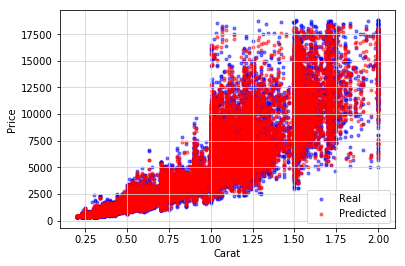

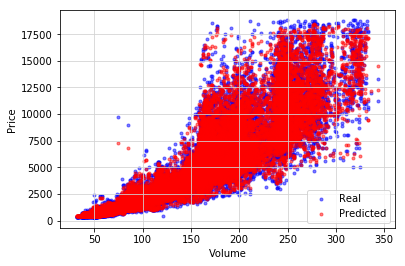

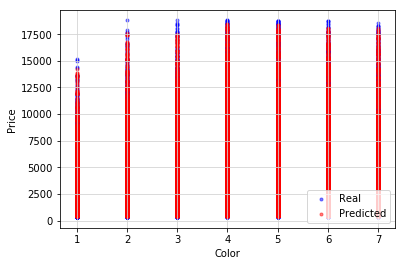

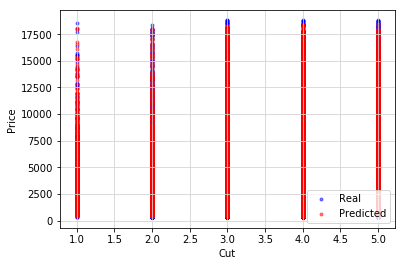

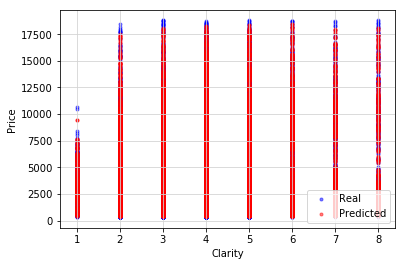

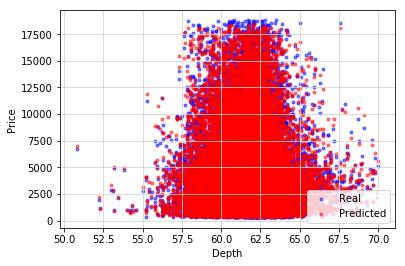

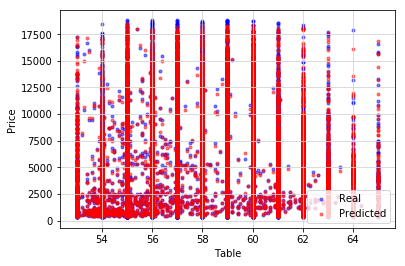

In [44]:
plt.scatter(X.carat, y, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(X.carat, preds, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('Carat')
plt.ylabel('Price')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

plt.scatter(X.volume, y, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(X.volume, preds, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('Volume')
plt.ylabel('Price')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

plt.scatter(X.color, y, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(X.color, preds, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('Color')
plt.ylabel('Price')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

plt.scatter(X.cut, y, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(X.cut, preds, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('Cut')
plt.ylabel('Price')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

plt.scatter(X.clarity, y, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(X.clarity, preds, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('Clarity')
plt.ylabel('Price')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()


plt.scatter(X.depth, y, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(X.depth, preds, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('Depth')
plt.ylabel('Price')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

plt.scatter(X.table, y, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(X.table, preds, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('Table')
plt.ylabel('Price')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

In fast alles Scatterplots lässt sich erkennen, dass die Performance im oberen Preissegment ab circa 17.000 Dollar abnimmt. Eine Idee zur Optimierung ist also, die besonders teuren Diamanten zu entfernen, da diese schlecht vorhergesagt werden und die Güte des Modells dadurch mindern.

# **Rücksprung und weitere Iteration zur Optimierung**<a class="anchor" id="optimierung"></a>

## Business und Data Understanding

Wie bereits in der ersten Analyse festgestellt, ist bei den Merkmale Tisch und Tiefe kein direkter Zusammenhang zu Preis erkennbar. Da das Modell die Merkmale nicht verwendet, sollten sie für die weitere Bearbeitung entfernt werden.

## Data Preparation

Die Merkmale Tisch und Tiefe werden entfernt. Diamanten mit einem Preis ab 11.885 Dollar gelten nach IQR-Methode als Ausreißer und werden aus den Daten entfernt.

In [50]:
data_reduced = data.copy()

print(len(data_reduced))

data_reduced = data_reduced.drop(['depth','table'], axis = 1)

data_reduced = data_reduced[data_reduced['price'] <= 11885]

print(len(data_reduced))
print(data_reduced.head(10))

y_reduced = data_reduced['price']
X_reduced = data_reduced.drop('price', axis = 1)

51770
49917
   carat  cut  color  clarity  price     volume
0   0.23    5      6        2    326  38.202030
1   0.21    4      6        3    326  34.505856
2   0.23    2      6        5    327  38.076885
3   0.29    4      2        4    334  46.724580
4   0.31    2      1        2    335  51.917250
5   0.24    3      1        6    336  38.693952
6   0.24    3      2        7    336  38.830870
7   0.26    3      3        3    337  42.321081
8   0.22    1      6        4    337  36.425214
9   0.23    3      3        5    338  38.718000


## Modeling und Evaluation

Zunächst werden der Parameter n_estimators durch GridSearch optimiert:

Fitting 15 folds for each of 12 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 22.7min finished


{'n_estimators': 600}
0.9802421745852581




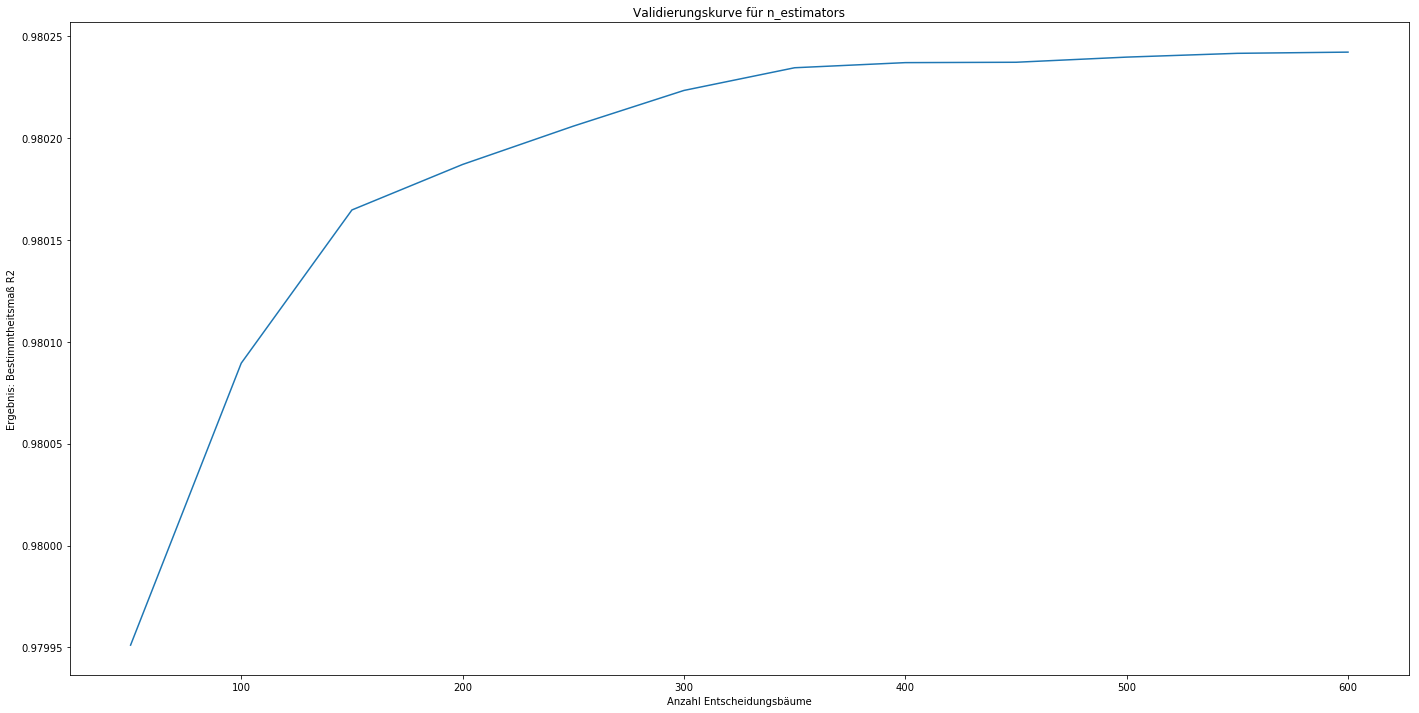

In [52]:
params = {'n_estimators': [50,100,150,200,250,300,350,400,450,500,550,600]}

model = RandomForestRegressor(criterion = 'mse', random_state = 0)

grid_search = GridSearchCV(model, params, cv = kfold, scoring = "r2", n_jobs = -1, verbose = 3)

grid_search.fit(X_reduced, y_reduced)

print(grid_search.best_params_)
print(grid_search.best_score_)
print("\n")

plt.figure(figsize = (24,12))
plt.plot(params['n_estimators'], grid_search.cv_results_['mean_test_score'])
plt.xlabel("Anzahl Entscheidungsbäume")
plt.ylabel("Ergebnis: Bestimmtheitsmaß R2")
plt.title("Validierungskurve für n_estimators")
plt.show()

Bei 350 Bäumen konvergiert die Validierungskurve. Hier ist also ein guter Mittelweg zwischen Performance und Güte des Modells gefunden worden.
Das Modell wird erneut auf eine Über- oder Unteranpassung untersucht:

In [55]:
model = RandomForestRegressor(n_estimators = 350, criterion = 'mse', random_state = 0)

cv_results = cross_validate(model, X_reduced, y_reduced, cv = kfold, scoring = scorer, return_train_score = True, n_jobs = -1)
    
print("Qualitätsmaß\t\t", "Trainingsdaten\t\t", "Testdaten\t")
print("Bestimmtheitsmaß (R²)\t", np.mean(cv_results["train_r2"]), "\t", np.mean(cv_results["test_r2"]))
print("Durchschn. Abs. Fehler\t", np.mean(cv_results["train_neg_mean_absolute_error"]*-1), "\t", np.mean(cv_results["test_neg_mean_absolute_error"]*-1))
print("Durchschn. Quad. Fehler\t", np.mean(cv_results["train_neg_mean_squared_error"]*-1), "\t", np.mean(cv_results["test_neg_mean_squared_error"]*-1))
print("Durchschn. Abs. Abw.\t", np.mean(cv_results["train_mean_absolute_deviation"]*-1), "\t", np.mean(cv_results["test_mean_absolute_deviation"]*-1))

Qualitätsmaß		 Trainingsdaten		 Testdaten	
Bestimmtheitsmaß (R²)	 0.997186090371724 	 0.9802622013485706
Durchschn. Abs. Fehler	 87.32895199046143 	 222.0826931543168
Durchschn. Quad. Fehler	 21066.955859747333 	 147763.8405610573
Durchschn. Abs. Abw.	 3.755112879130475 	 8.647891146469153


Es zeigt sich erneut eine leichte Überanpassung, allerdings weniger stark als bei den nicht reduzierten Daten. Daher werden erneut folgende Parameter mit der RandomizedGridSearch optimiert:
* max_depth
* min_samples_split
* min_samples_leaf
* min_impurity_decrease

In [54]:
params = {'max_depth': [30,40,50,60,70,80,90,100,110],
          'min_samples_split' : [2,3,4,6,8,10,12,14],
          'min_samples_leaf' : [2,3,4,6,8,10,12,14],
          'min_impurity_decrease' : [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

model = RandomForestRegressor(n_estimators = 350, criterion = 'mse', random_state = 0)

random_search = RandomizedSearchCV(model, params, cv = kfold, scoring = "r2", n_iter = 250, n_jobs = -1, verbose = 3)

random_search.fit(X_reduced, y_reduced)

print(random_search.best_params_)
print(random_search.best_score_)
print("\n")

Fitting 15 folds for each of 250 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 37.5min
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed: 67.6min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 85.1min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 104.7min
[Parallel(n_jobs=-1)]: Done 3750 out of 3750 | elapsed: 123.1min finished


{'min_samples_split': 12, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.9, 'max_depth': 60}
0.9810941680866445




Im Folgenden wird das Modell eingestellt mit:
* n_estimators = 200
* max_depth = 90
* min_samples_split = 4
* min_samples_leaf = 2
* min_impurity_decrease = 0.7
* criterion = 'mse'

Auch hier konnte wieder nur eine geringfügige Verbesserung erzielt werden:

In [56]:
model = RandomForestRegressor(n_estimators = 350, max_depth = 60, min_samples_split = 12, min_samples_leaf = 2, min_impurity_decrease = 0.9, criterion = 'mse', random_state = 0)

cv_results = cross_validate(model, X_reduced, y_reduced, cv = kfold, scoring = scorer, return_train_score = True, n_jobs = -1)
    
print("Qualitätsmaß\t\t", "Trainingsdaten\t\t", "Testdaten\t")
print("Bestimmtheitsmaß (R²)\t", np.mean(cv_results["train_r2"]), "\t", np.mean(cv_results["test_r2"]))
print("Durchschn. Abs. Fehler\t", np.mean(cv_results["train_neg_mean_absolute_error"]*-1), "\t", np.mean(cv_results["test_neg_mean_absolute_error"]*-1))
print("Durchschn. Quad. Fehler\t", np.mean(cv_results["train_neg_mean_squared_error"]*-1), "\t", np.mean(cv_results["test_neg_mean_squared_error"]*-1))
print("Durchschn. Abs. Abw.\t", np.mean(cv_results["train_mean_absolute_deviation"]*-1), "\t", np.mean(cv_results["test_mean_absolute_deviation"]*-1))

Qualitätsmaß		 Trainingsdaten		 Testdaten	
Bestimmtheitsmaß (R²)	 0.9897586809598157 	 0.9811042568880483
Durchschn. Abs. Fehler	 163.0923084681741 	 216.24534365320315
Durchschn. Quad. Fehler	 76674.4375943686 	 141457.53050647143
Durchschn. Abs. Abw.	 6.421544718106531 	 7.994499225084064


Die Verbesserung nach der Entfernung der teuren Diamanten ist nur sehr gering. Das Bestimmtheitsmaß hat sich nur gering verbessert, die durchschnittliche absolute Abweichung hat sich sogar minimal verschlechtert. Sowohl der durchschnittliche absolute und durquadrierte Fehler haben sich zwar verbessert, die kann allerdings nicht zwangsweise auf ein besseres Modell zurückgeführt werden. Bei teureren Diamanten führt eine Abweichung von etwa 8 Prozent zu nominell größeren Werten als bei günstigen Diamanten. Wenn nun die teureren Diamanten entfernt werden, sinken der durchschnittliche und der absolute Fehler, obwohl die Vorhersagen nicht zwangsweise besser sind.

Die Optimierung hat also zu keiner Verbesserung des Modells geführt und wird daher zurückgenommen.

# **Ergebnis**<a class="anchor" id="ergebnis"></a>

Der folgende Quelltext ließt die Daten ein und führt eine korrekte Datenvorbereitung durch und implementiert die Methode zur Berechnung der durchschnittlichen absoluten Abweichung:

In [67]:
#Daten neu einlesen
data = pd.read_csv('diamonds.csv') #https://www.kaggle.com/shivam2503/diamonds
data = data.drop('Unnamed: 0', 1) #Zeilennummer in CSV-Datei, kann daher entfernt werden

print("Vor Datenvorbereitung:\n")
print(data.head(10))

#Falsche Daten und Ausreißer aus x, y und z entfernen
data = data[data['x'] > 1.965]
data = data[data['x'] < 9.285]
data = data[data['y'] > 2.01]
data = data[data['y'] < 9.27]
data = data[data['z'] > 1.215]
data = data[data['z'] < 5.735]

#Ausreißer aus Karat entfernen (größer als 2,0)
data = data[data['carat'] <= 2.0]

#Ausreißer aus Tiefe entfernen (größer als 70 und kleiner als 50)
data = data[data['depth'] <= 70]
data = data[data['depth'] >= 50]

#Ausreißer aus Tisch entfernen (größer als 65 und kleiner als 53)
data = data[data['table'] <= 65]
data = data[data['table'] >= 53]

#Volumen erzeugen und x, y und z entfernen
data['volume'] = data['x']*data['y']*data['z']
data.drop(['x','y','z'], axis=1, inplace=True)

#Ordinale Merkmale kodieren
data['cut'] = data['cut'].apply(lambda x: 1 if x=='Fair' 
                                     else(2 if x=='Good' 
                                     else(3 if x=='Very Good' 
                                     else(4 if x=='Premium' else 5))))

data['color'] = data['color'].apply(lambda x: 1 if x=='J' 
                                         else(2 if x=='I'
                                         else(3 if x=='H'
                                         else(4 if x=='G'
                                         else(5 if x=='F'
                                         else(6 if x=='E' else 7))))))

data['clarity'] = data['clarity'].apply(lambda x: 1 if x=='I1' 
                                             else(2 if x=='SI2'
                                             else(3 if x=='SI1'
                                             else(4 if x=='VS2'
                                             else(5 if x=='VS1'
                                             else(6 if x=='VVS2'
                                             else 7 if x=='VVS1' else 8))))))

print("\nNach Bereinigung:\n")
print(data.head(10))

#Merkmale und Zielvariable trennen
y = data['price']
X = data.drop(['price'], axis = 1)

def mean_absolute_deviation(y_true_list, y_pred_list):
    
    sum_deviation = 0
    
    for y_true, y_pred in zip(y_true_list, y_pred_list):
        
        deviation = (((y_pred / y_true) - 1) * 100)
        
        if deviation >= 0:
            
            sum_deviation += deviation
            
        if deviation < 0:
            
            sum_deviation += (deviation * -1)
        
    return (sum_deviation / len(y_true_list))

Vor Datenvorbereitung:

   carat        cut color clarity  depth  table  price     x     y     z
0   0.23      Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21    Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23       Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
5   0.24  Very Good     J    VVS2   62.8   57.0    336  3.94  3.96  2.48
6   0.24  Very Good     I    VVS1   62.3   57.0    336  3.95  3.98  2.47
7   0.26  Very Good     H     SI1   61.9   55.0    337  4.07  4.11  2.53
8   0.22       Fair     E     VS2   65.1   61.0    337  3.87  3.78  2.49
9   0.23  Very Good     H     VS1   59.4   61.0    338  4.00  4.05  2.39

Nach Bereinigung:

   carat  cut  color  clarity  depth  table  price     volume
0   0.23    5      6        2   61.5   55.0    326  38.202030
1   0.21    4      6        3

Als Modell wird ein RandomForestRegressor mit folgender Konfiguration verwendet:
* n_estimators = 350
* max_depth = 60
* min_samples_split = 12
* min_samples_leaf = 2
* min_impurity_decrease = 0.9
* criterion = 'mse'

In [64]:
model = RandomForestRegressor(n_estimators = 350, max_depth = 60, min_samples_split = 12, min_samples_leaf = 2, min_impurity_decrease = 0.9, criterion = 'mse', random_state = 0)
model.fit(X, y)

preds = model.predict(X)

In [110]:
print(model)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.9, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=12,
           min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)


In [68]:
print("Qualitätsmaß\t\t", "Ergebnis")
print("Bestimmtheitsmaß (R²)\t", r2_score(y, preds))
print("Durchschn. Abs. Fehler\t", mean_absolute_error(y, preds))
print("Durchschn. Quad. Fehler\t", mean_squared_error(y, preds))
print("Durchschn. Abs. Abw.\t", mean_absolute_deviation(y, preds))

Qualitätsmaß		 Ergebnis
Bestimmtheitsmaß (R²)	 0.9919930869273788
Durchschn. Abs. Fehler	 167.67552627962226
Durchschn. Quad. Fehler	 93414.48044322399
Durchschn. Abs. Abw.	 5.9693011542081535


Das Modell bildet die Daten zu etwa 99 % ab.

Vorhersagen liegen im Durchschnitt um etwa 167 Dollar bzw. 6,0 Prozent daneben.

Damit ist das Ziel von maximal 15 % Abweichung erfüllt.

Zu beachten ist, dass das finale Modell im Gegensatz zu den anderen Modellen mit allen verfügbaren Daten trainiert wurde. Von daher wird die Güte des Modells beim Umgang mit unbekannten Daten vermutlich schlechter abschneiden.

In [69]:
characteristics = X.columns
importances = list(model.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];

Variable: carat                Importance: 0.64
Variable: volume               Importance: 0.23
Variable: clarity              Importance: 0.08
Variable: color                Importance: 0.04
Variable: cut                  Importance: 0.0
Variable: depth                Importance: 0.0
Variable: table                Importance: 0.0


Das Modell basiert zu 64 % auf dem Merkmal carat und zu 23 % auf dem Merkmal volume. Diese beiden Merkmale hängen jeweils selbst stark zusammen. Man erkennt also auch hier, dass das Gewicht bzw. die Größe des Diamanten der mit Abstand wichtigste Faktor für den Preis eines Diamanten ist.

Abschließend wird eine Stichprobe aus den Daten mit dem Modell vorhergesagt. Die Abweichungen können der Tabelle entnommen werden.

In [109]:
test_data = data.sample(10)
y_test_data = test_data['price']
X_test_data = test_data.drop(['price'], axis = 1)

test_preds = model.predict(X_test_data)

print("Qualitätsmaß\t\t", "Ergebnis")
print("Bestimmtheitsmaß (R²)\t", r2_score(y_test_data, test_preds))
print("Durchschn. Abs. Fehler\t", mean_absolute_error(y_test_data, test_preds))
print("Durchschn. Quad. Fehler\t", mean_squared_error(y_test_data, test_preds))
print("Durchschn. Abs. Abw.\t", mean_absolute_deviation(y_test_data, test_preds))

test_results = X_test_data.copy()

test_results["price"] = y_test_data
test_results["Vorhersage"] = test_preds
test_results["Verhältnis"] = round((((test_preds / y_test_data) - 1) * 100), 2)
test_results["Differenz"] = y_test_data - test_preds

print("\n\n")
print(test_results)

Qualitätsmaß		 Ergebnis
Bestimmtheitsmaß (R²)	 0.9947325094692051
Durchschn. Abs. Fehler	 106.88320535308966
Durchschn. Quad. Fehler	 39480.360112750524
Durchschn. Abs. Abw.	 3.660973864395524



       carat  cut  color  clarity  depth  table      volume  price    Vorhersage  Verhältnis   Differenz
47931   0.56    4      6        4   61.8   59.0   92.305104   1915   1854.472174       -3.16   60.527826
52375   0.71    3      5        3   59.0   61.0  118.813632   2505   2497.377033       -0.30    7.622967
43575   0.41    5      6        7   60.9   55.0   67.929120   1431   1424.293005       -0.47    6.706995
47594   0.53    4      7        4   62.4   59.0   85.733144   1877   1841.309119       -1.90   35.690881
49549   0.59    5      4        5   61.3   55.0   98.184384   2129   2004.246165       -5.86  124.753835
28925   0.30    5      4        6   61.5   55.0   49.226400    684    734.839519        7.43  -50.839519
40368   0.50    5      2        5   61.9   54.0   84.013056   1130   

## Zusammenfassung

Ziel des Projekts war die Erstellung eines Regressionsmodells zur Vorhersage von Diamant-Preisen nach dem CRISP-DM-Modell. Zur Verfügung standen circa 53.000 Datensätze mit jeweils neun Merkmalen bezüglich Abmessungen und Qualität.
Während des Business Understandings wurde zunächst der Kontext dargestellt und ein konkretes Ziel formuliert: Die möglichst genaue Vorhersage der Diamant-Preise mittels Regression, wobei die Abweichung der Vorhersage vom echten Preis im Durchschnitt nicht über 15 % liegen sollte.
Im Data Understanding wurden dann folgende Erkenntnisse gewonnen:

1.	Die Daten sind sehr ungleich verteilt
2.	Karat und Größe des Diamanten haben sehr starken Einfluss auf den Preis
3.	Höhe, Breite und Länge lassen sich aufgrund des starken linearen Zusammenhangs zusammenfassen
4.	Reinheit, Farbe und Schliff beeinflussen den Preis ebenfalls positiv
<br>Allerdings sind viele ansonsten hochwertige Diamanten in niedrigen Gewichtsklassen und daher günstiger als die schwereren Pendants, welche generell bei anderen Qualitätsmerkmalen schlechter sind. Das Gewicht gleicht diese Defizite allerdings mehr als aus, wodurch auf den ersten Blick der Anschein entstehen kann, dass hochwertigere Diamanten günstiger sind als weniger hochwertige.
5.	Die Merkmale Tisch und Tiefe weisen keinen sichtbaren Zusammenhang zum Preis auf

Bei der Data Preparation wurden einige falsche Datensätze und Ausreißer entfernt und die ordinalen Merkmale in numerische Werte umgewandelt.

Während der Modeling- und Evaluation-Phase wurde zunächst ein geeigneter Algorithmus ausgewählt und optimiert. Nach einer Untersuchung auf Über- und Unteranpassungen konnte festgestellt werden, dass das Modell überanpasst. Daher wurde versucht, die Überanpassung durch Hyperparameter-Optimierung zu kompensieren, was allerdings nur bedingt gelang. Auch eine Reduktion der Daten durch Entfernen der besonders teuren Diamanten hat keine Verbesserung herbeigeführt.

Abschließend wurde folgendes Modell erstellt:

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.9, min_impurity_split=None, min_samples_leaf=2, min_samples_split=12, min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=None, oob_score=False, random_state=0, verbose=0, warm_start=False)

Das Modell weicht bei Vorhersagen im Schnitt etwa 6 % vom tatsächlichen Preis ab, was 170 Dollar entspricht. Damit ist das Ziel zunächst erfüllt. Es müsste nun allerdings geprüft werden, wie gut das Modell in der Realität arbeitet.

# **Quellen**<a class="anchor" id="optimierung"></a>

[1]<a class="anchor" id="diamanten-4cs"></a> renesim GmbH (2020): Vier C – Carat, Clarity, Colour und Cut, abgerufen am 01.06.2020 unter: <br>https://www.renesim.com/de/de/wissen/diamantenlexikon/vier-c/die-vier-c

[2]<a class="anchor" id="crispdmmodellbild"></a> IBM Knowledge Center (2020): CRISP-DM-Hilfe - Übersicht, abgerufen am 01.06.2020 unter: <br>https://www.ibm.com/support/knowledgecenter/de/SS3RA7_sub/modeler_crispdm_ddita/clementine/crisp_help/crisp_overview.html

[3]<a class="anchor" id="crispdmmodell"></a> Luber, Stefan; Litzel, Nico (2019): Was ist CRISP-DM?, abgerufen am 01.06.2020 unter: 
<br>https://www.bigdata-insider.de/was-ist-crisp-dm-a-815478/

[4]<a class="anchor" id="datensatz"></a> Kaggle (2020): Diamonds, abgerufen am 01.05.2020 unter: 
<br>https://www.kaggle.com/shivam2503/diamonds

[5]<a class="anchor" id="abmessungen"></a> Eigene Darstellung basierend auf: Kaggle (2020): Diamonds, abgerufen am 01.06.2020 unter: 
<br>https://www.kaggle.com/shivam2503/diamonds

[6]<a class="anchor" id="verteilungsdiagramm"></a> seaborn (2020): seaborn.distplot, abgerufen am 01.06.2020 unter: 
<br>https://seaborn.pydata.org/generated/seaborn.distplot.html#

[7]<a class="anchor" id="boxplot"></a> seaborn (2020): seaborn.boxplot, abgerufen am 01.06.2020 unter: 
<br>https://seaborn.pydata.org/generated/seaborn.boxplot.html

[8]<a class="anchor" id="regressionsplot"></a> seaborn (2020): seaborn.regplot, abgerufen am 01.06.2020 unter: 
<br>https://seaborn.pydata.org/generated/seaborn.regplot.html

[9]<a class="anchor" id="spearmanpearson"></a> Minitab.com: Ein Vergleich der Korrelationsmethode nach Pearson und nach Spearman, abgerufen am 01.06.2020 unter: 
<br>https://support.minitab.com/de-de/minitab/19/help-and-how-to/statistics/basic-statistics/supporting-topics/correlation-and-covariance/a-comparison-of-the-pearson-and-spearman-correlation-methods/

[10]<a class="anchor" id="scipyspearman"></a> SciPy.org (2019): scipy.stats.spearmanr, abgerufen am 01.06.2020 unter: 
<br>https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html

[11]<a class="anchor" id="scipypearson"></a> SciPy.org (2019): scipy.stats.pearsonr, abgerufen am 01.06.2020 unter: 
<br>https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

[12]<a class="anchor" id="qrmethode"></a> Günter, Prof. Dr. Daniel Rey (2020): Auswertung Ausreißer, abgerufen am 01.06.2020 unter: 
<br>http://www.elearning-psychologie.de/ausreisser.html

[13]<a class="anchor" id="countplot"></a> seaborn (2020): seaborn.countplot, abgerufen am 01.06.2020 unter: 
<br>https://seaborn.pydata.org/generated/seaborn.countplot.html

[14]<a class="anchor" id="barplot"></a> seaborn (2020): seaborn.barplot, abgerufen am 01.06.2020 unter: 
<br>https://seaborn.pydata.org/generated/seaborn.barplot.html

[15]<a class="anchor" id="varianzanalyse"></a> Universität Zürich (2018): Einfaktorielle Varianzanalyse (ohne Messwiederholung), abgerufen am 01.06.2020 unter: 
<br>https://www.methodenberatung.uzh.ch/de/datenanalyse_spss/unterschiede/zentral/evarianz.html

[16]<a class="anchor" id="karat"></a> renesim GmbH (2020): Karat (Carat), abgerufen am 01.06.2020 unter: 
<br>https://www.renesim.com/de/de/wissen/diamantenlexikon/vier-c/karat

[17]<a class="anchor" id="schliff"></a> renesim GmbH (2020): Cut (Schliff), abgerufen am 01.06.2020 unter: 
<br>https://www.renesim.com/de/de/wissen/diamantenlexikon/vier-c/cut

[18]<a class="anchor" id="schliffreihenfolge"></a> LooseDiamondsReviews.com (2011): The fourth – and most important – of the Four Cs: Cut, abgerufen am 01.06.2020 unter: 
<br>https://www.loosediamondsreviews.com/diamondcut.html

[19]<a class="anchor" id="farbe"></a> renesim GmbH (2020): Farbe (Colour), abgerufen am 01.06.2020 unter: 
<br>https://www.renesim.com/de/de/wissen/diamantenlexikon/vier-c/farbe

[20]<a class="anchor" id="reinheit"></a> renesim GmbH (2020): Clarity (Reinheit), abgerufen am 01.06.2020 unter: 
<br>https://www.renesim.com/de/de/wissen/diamantenlexikon/vier-c/clarity

[21]<a class="anchor" id="dataframe"></a> pandas development team (2014): pandas.DataFrame, abgerufen am 01.06.2020 unter: 
<br>https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html

[22]<a class="anchor" id="heatmap"></a> seaborn (2020): seaborn.heatmap, abgerufen am 01.06.2020 unter: 
<br>https://seaborn.pydata.org/generated/seaborn.heatmap.html

[23]<a class="anchor" id="pairplot"></a> seaborn (2020): seaborn.pairplot, abgerufen am 01.06.2020 unter: 
<br>https://seaborn.pydata.org/generated/seaborn.pairplot.html

[24]<a class="anchor" id="scatterplot"></a> seaborn (2020): seaborn.scatterplot, abgerufen am 01.06.2020 unter: 
<br>https://seaborn.pydata.org/generated/seaborn.scatterplot.html

[25]<a class="anchor" id="standardscaler"></a> scikit-learn developers (2019): sklearn.preprocessing.StandardScaler, abgerufen am 01.06.2020 unter: 
<br>https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

[26]<a class="anchor" id="bestimmtheitsmaß"></a> scikit-learn developers (2019): sklearn.metrics.r2_score, abgerufen am 01.06.2020 unter: 
<br>https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score

[27]<a class="anchor" id="absoluterfehler"></a> scikit-learn developers (2019): sklearn.metrics.mean_absolute_error, abgerufen am 01.06.2020 unter: 
<br>https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error

[28]<a class="anchor" id="quadrierterfehler"></a> scikit-learn developers (2019): sklearn.metrics.mean_squared_error, abgerufen am 01.06.2020 unter: 
<br>https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error

[29]<a class="anchor" id="makescorer"></a> scikit-learn developers (2019): sklearn.metrics.make_scorer, abgerufen am 01.06.2020 unter: 
<br>https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html

[30]<a class="anchor" id="kreuzvalidierung"></a> Raschka, Sebastian/Mirjalili Vahid: Machine Learning mit
Python und Scikit-learn und TensorFlow: Das umfassende Praxis-Handbuch für
Data Science, Deep Learning und Predictive Analytics, Seite 207 ff.

Frechen: mitp Verlag, 2018

[31]<a class="anchor" id="cross_validate"></a> scikit-learn developers (2019): sklearn.model_selection.cross_validate, abgerufen am 01.06.2020 unter: 
<br>https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

[32]<a class="anchor" id="repeatedkfold"></a> scikit-learn developers (2019): sklearn.model_selection.RepeatedKFold, abgerufen am 01.06.2020 unter: 
<br>https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html

[33]<a class="anchor" id="algorithmen"></a> scikit-learn developers (2019): 1. Supervised learning, abgerufen am 01.06.2020 unter: 
<br>https://scikit-learn.org/stable/supervised_learning.html

[34]<a class="anchor" id="randomforest"></a> scikit-learn developers (2019): 1. sklearn.ensemble.RandomForestRegressor, abgerufen am 01.06.2020 unter: 
<br>https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

[30]<a class="anchor" id="kreuzvalidierung"></a> Raschka, Sebastian/Mirjalili Vahid: Machine Learning mit
Python und Scikit-learn und TensorFlow: Das umfassende Praxis-Handbuch für
Data Science, Deep Learning und Predictive Analytics, Seite 346 ff.

Frechen: mitp Verlag, 2018

[36]<a class="anchor" id="gridsearch"></a> scikit-learn developers (2019): sklearn.model_selection.GridSearchCV, abgerufen am 01.06.2020 unter: 
<br>https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

[37]<a class="anchor" id="kreuzvalidierung"></a> Raschka, Sebastian/Mirjalili Vahid: Machine Learning mit
Python und Scikit-learn und TensorFlow: Das umfassende Praxis-Handbuch für
Data Science, Deep Learning und Predictive Analytics, Seite 211 ff.

Frechen: mitp Verlag, 2018

[38]<a class="anchor" id="randomizedsearch"></a> scikit-learn developers (2019): sklearn.model_selection.RandomizedSearchCV, abgerufen am 01.06.2020 unter: 
<br>https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html